# Reporte: Análisis de incidencia delictiva en la Ciudad de México mediante series de tiempo y análisis bayesiano

A continuación se expone lo realizado para la elaboración de la presente práctica, así como los resultados obtenidos.

## Sobre las fuentes de información

La información utilizada en el presente trabajo se obtuvo de tres fuentes:
* [Portal de datos de la Ciudad de México](https://datos.cdmx.gob.mx).
* [Instituto Nacional de Estadística y Geografía (INEGI)](https://www.inegi.org.mx).
* [Consejo Nacional de Población (CONAPO)](https://www.gob.mx/conapo).

## Sobre los datos

La información sobre los delitos denunciados se obtuvieron del portal de __[Datos Abiertos](https://datos.cdmx.gob.mx/explore/dataset/carpetas-de-investigacion-pgj-cdmx/export/)__ de la Ciudad de México, mientras que la información relativa al índice de marginación, y variables utilizadas para su construcción, se obtuvo del __[CONAPO](http://www.conapo.gob.mx/es/CONAPO/Datos_Abiertos_del_Indice_de_Marginacion)__. Por último la información referente al tamaño de la población fue consultada en el portal del __[INEGI](https://www.inegi.org.mx/programas/ccpv/2010/default.html#Tabulados)__.

Esta información está contenida en los archivos:
* [datos_delitos.rds](datos_delitos.rds). Contiene las denunias hechas por día desde enero de 2017 hasta junio de 2019.
* [Base_Indice_de_marginacion_municipal.csv](Base_Indice_de_marginacion_municipal.csv). Contiene el índice de marginación (_IM_) y algunas de las variables utlizadas para su construcción con información del CONAPO de 2015.
* [datos_pob.csvdatos_pob.csv](datos_pob.csv). Contiene información sobre el tamaño de la población de la Ciudad de México por alcaldía, incluye información desagregada por género.

## Alcance del proyecto

Usando los datos proporcionados por la Secretaría de Seguridad Ciudadana de la Ciudad de México, se realizó un análisis de series de tiempo para conocer el comportamiento, frecuencia y patrón de ocurrencia de delitos en la Ciudad de México. A través de este estudio se logró identificar los días en los que se reportan más delitos. Se observó la cantidad de delitos en cada una de las alcaldías de la Ciudad y se realizó un análisis de correlación entre la cantidad poblacional en cada alcaldía, el volumen de delitos reportados y el índice de marginación de cada alacaldía.

Adicionalmente, se realizó un análisis bayesiano que tiene por objetivo especificar la distribución del parámetro $\lambda$ si se asigna una distribución $Poisson$ al número de denuncias presentadas en cada alcaldía.

## Análisis descriptivo

Para el análisis descriptivo se requirió el paquete y configuraciones siguientes:

In [3]:
library(tidyverse)
options(digits=4, big.mark = ',', repr.plot.width=22, repr.plot.height=8)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.1     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Para este anális se requirió cargar las base [datos_delitos.rds](datos_delitos.rds):

In [56]:
marg_index <- read.csv('Base_Indice_de_marginacion_municipal.csv')

months <- c('January','February','March','April','May','June','July','August','September','October','November','December')

delitos <- readRDS('datos_delitos.rds') %>%
    mutate(categoria_delito = factor(categoria_delito),
           alcaldia_hechos = factor(alcaldia_hechos),
           año = factor(format(fecha_hechos,'%Y')),
           mes = factor(format(fecha_hechos,'%B'), level = months),
           CVE_MUN = case_when(
               alcaldia_hechos == 'ALVARO OBREGON' ~ 9010,
               alcaldia_hechos == 'AZCAPOTZALCO' ~ 9002,
               alcaldia_hechos == 'BENITO JUAREZ' ~ 9014,
               alcaldia_hechos == 'COYOACAN' ~ 9003,
               alcaldia_hechos == 'CUAJIMALPA DE MORELOS' ~ 9004,
               alcaldia_hechos == 'CUAUHTEMOC' ~ 9015,
               alcaldia_hechos == 'GUSTAVO A MADERO' ~ 9005,
               alcaldia_hechos == 'IZTACALCO' ~ 9006,
               alcaldia_hechos == 'IZTAPALAPA' ~ 9007,
               alcaldia_hechos == 'LA MAGDALENA CONTRERAS' ~ 9008,
               alcaldia_hechos == 'MIGUEL HIDALGO' ~ 9016,
               alcaldia_hechos == 'MILPA ALTA' ~ 9009,
               alcaldia_hechos == 'TLAHUAC' ~ 9011,
               alcaldia_hechos == 'TLALPAN' ~ 9012,
               alcaldia_hechos == 'VENUSTIANO CARRANZA' ~ 9017,
               alcaldia_hechos == 'XOCHIMILCO' ~ 9013)) %>%
    select(CVE_MUN, año, mes, alcaldia_hechos,categoria_delito)

Así, si se agrupan los datos por mes, año y alcaldía, se tendrán un total de $5,760$ observaciones mensuales, cuyo valor son las cantidades de denuncias realizadas al mes por año y por delegación, con lo cuál se puede obtener una tabla de cuántiles medias cómo se muestra a continuación.

In [18]:
(d.alc <- delitos %>%
    group_by(alcaldia_hechos, año, mes) %>%
    tally(sort = TRUE)) %>%
    with(sapply(split(n,alcaldia_hechos),summary)) %>%
    t() %>%
    format(digits = 2, big.mark = ',') %>%
    as.data.frame() %>%
    rownames_to_column(var = 'Alcaldía')

Alcaldía,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.
<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
ALVARO OBREGON,"1,031","1,168","1,276","1,256","1,351","1,472"
AZCAPOTZALCO,674,880,920,926,990,"1,069"
BENITO JUAREZ,"1,241","1,609","1,686","1,680","1,789","2,112"
COYOACAN,994,"1,176","1,278","1,261","1,357","1,491"
CUAJIMALPA DE MORELOS,207,247,266,265,279,330
CUAUHTEMOC,"2,148","2,782","3,039","2,967","3,177","3,513"
GUSTAVO A MADERO,"1,452","1,828","1,920","1,885","2,006","2,130"
IZTACALCO,646,763,840,834,908,"1,027"
IZTAPALAPA,"2,257","2,642","2,794","2,780","2,920","3,088"


Con su respectiva gráfica de boxplot:

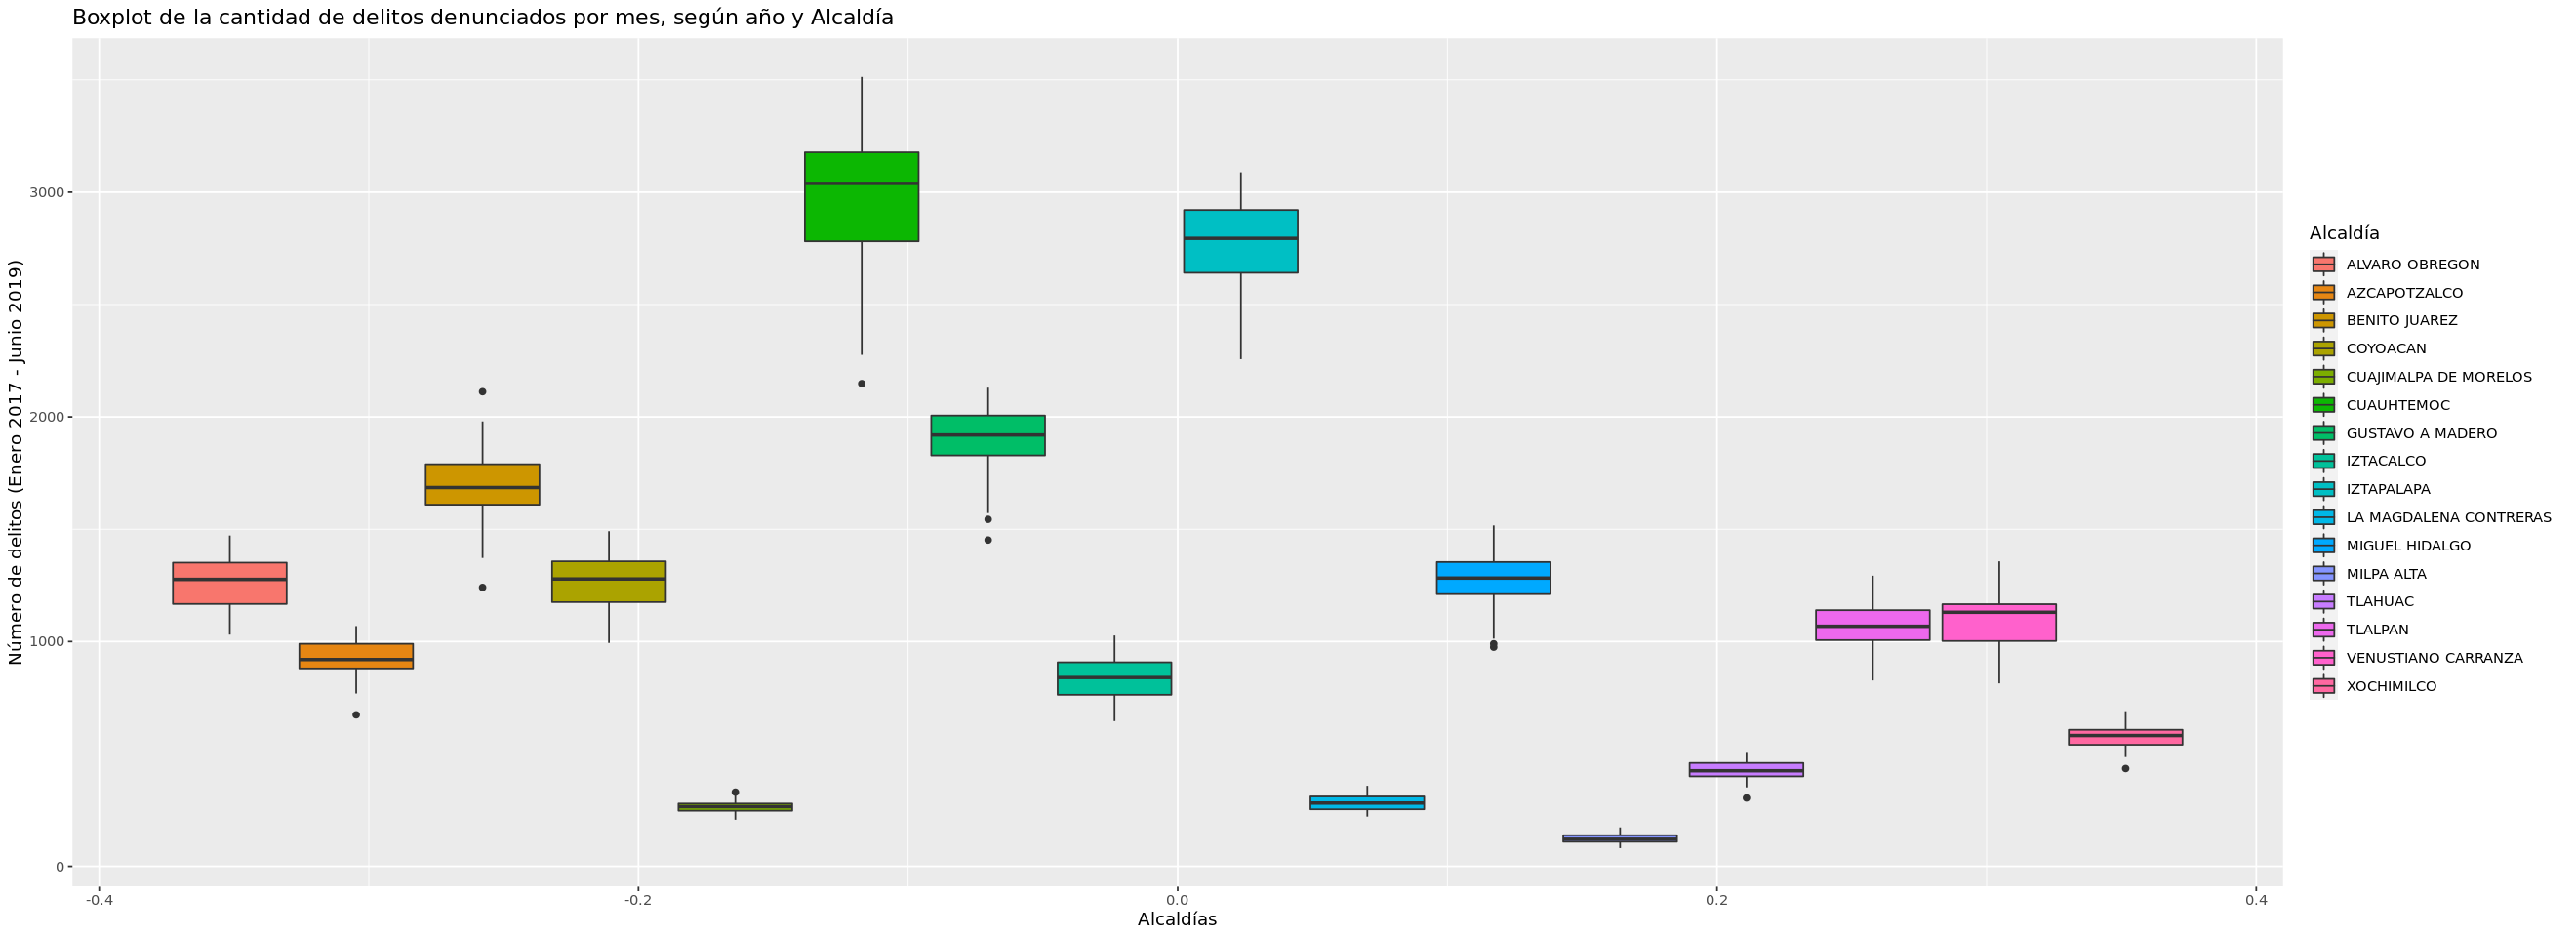

In [6]:
ggplot(d.alc,aes(n)) +
    geom_boxplot(aes(fill = alcaldia_hechos)) +
    coord_flip() +
    labs(x = 'Número de delitos (Enero 2017 - Junio 2019)',
         y = 'Alcaldías',
         title = 'Boxplot de la cantidad de delitos denunciados por mes, según año y Alcaldía',
         fill = 'Alcaldía')

Con lo cual se aprecia que alcaldías como _CUAUHTEMOC_, _GUSTAVO A MADERO_ e _IZTAPALAPA_ son las delegaciones con un mayor número de denuncias por mes, a su ves la alcaldía _CUAUHTEMOC_ es la alcaldía con un mayor rango intercuantil de $395$ denuncias. Por otro lado, alcaldías como _CUAJIMALPA DE MORELOS_, _LA MAGDALENA CONTRERAS_ y _MILPA ALTA_ son las de alcandías con un menor número de denuncias.

Por otro lado, si se reproduce el mismo análisis, pero en lugar de agrupar por alcaldías se agrupa por tipo de delito se obtiene lo siguiente:

In [19]:
(d.del <- delitos %>%
    group_by(categoria_delito, año, mes) %>%
    tally(sort = TRUE)) %>%
    with(sapply(split(n,categoria_delito),summary)) %>%
    t() %>%
    format(digits = 2, big.mark = ',') %>%
    as.data.frame() %>%
    rownames_to_column(var = 'Delito')

Delito,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.
<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
DELITO DE BAJO IMPACTO,"11,564.0","13,906.8","14,683.0","14,803.7","16,257.0","17,633.0"
HECHO NO DELICTIVO,236.0,555.0,"1,288.0","1,060.3","1,445.2","1,651.0"
HOMICIDIO DOLOSO,62.0,81.0,94.5,95.8,107.5,147.0
LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,48.0,71.0,78.5,77.4,86.8,105.0
ROBO A CASA HABITACIÓN CON VIOLENCIA,28.0,34.2,39.0,43.9,49.8,76.0
ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA,11.0,24.5,30.5,33.5,39.8,61.0
ROBO A NEGOCIO CON VIOLENCIA,147.0,216.5,251.5,291.6,347.0,590.0
ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,43.0,54.2,59.5,67.2,78.5,121.0
ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,5.0,12.2,15.5,17.5,19.8,48.0


Con su respectiva gráfica de boxplot:

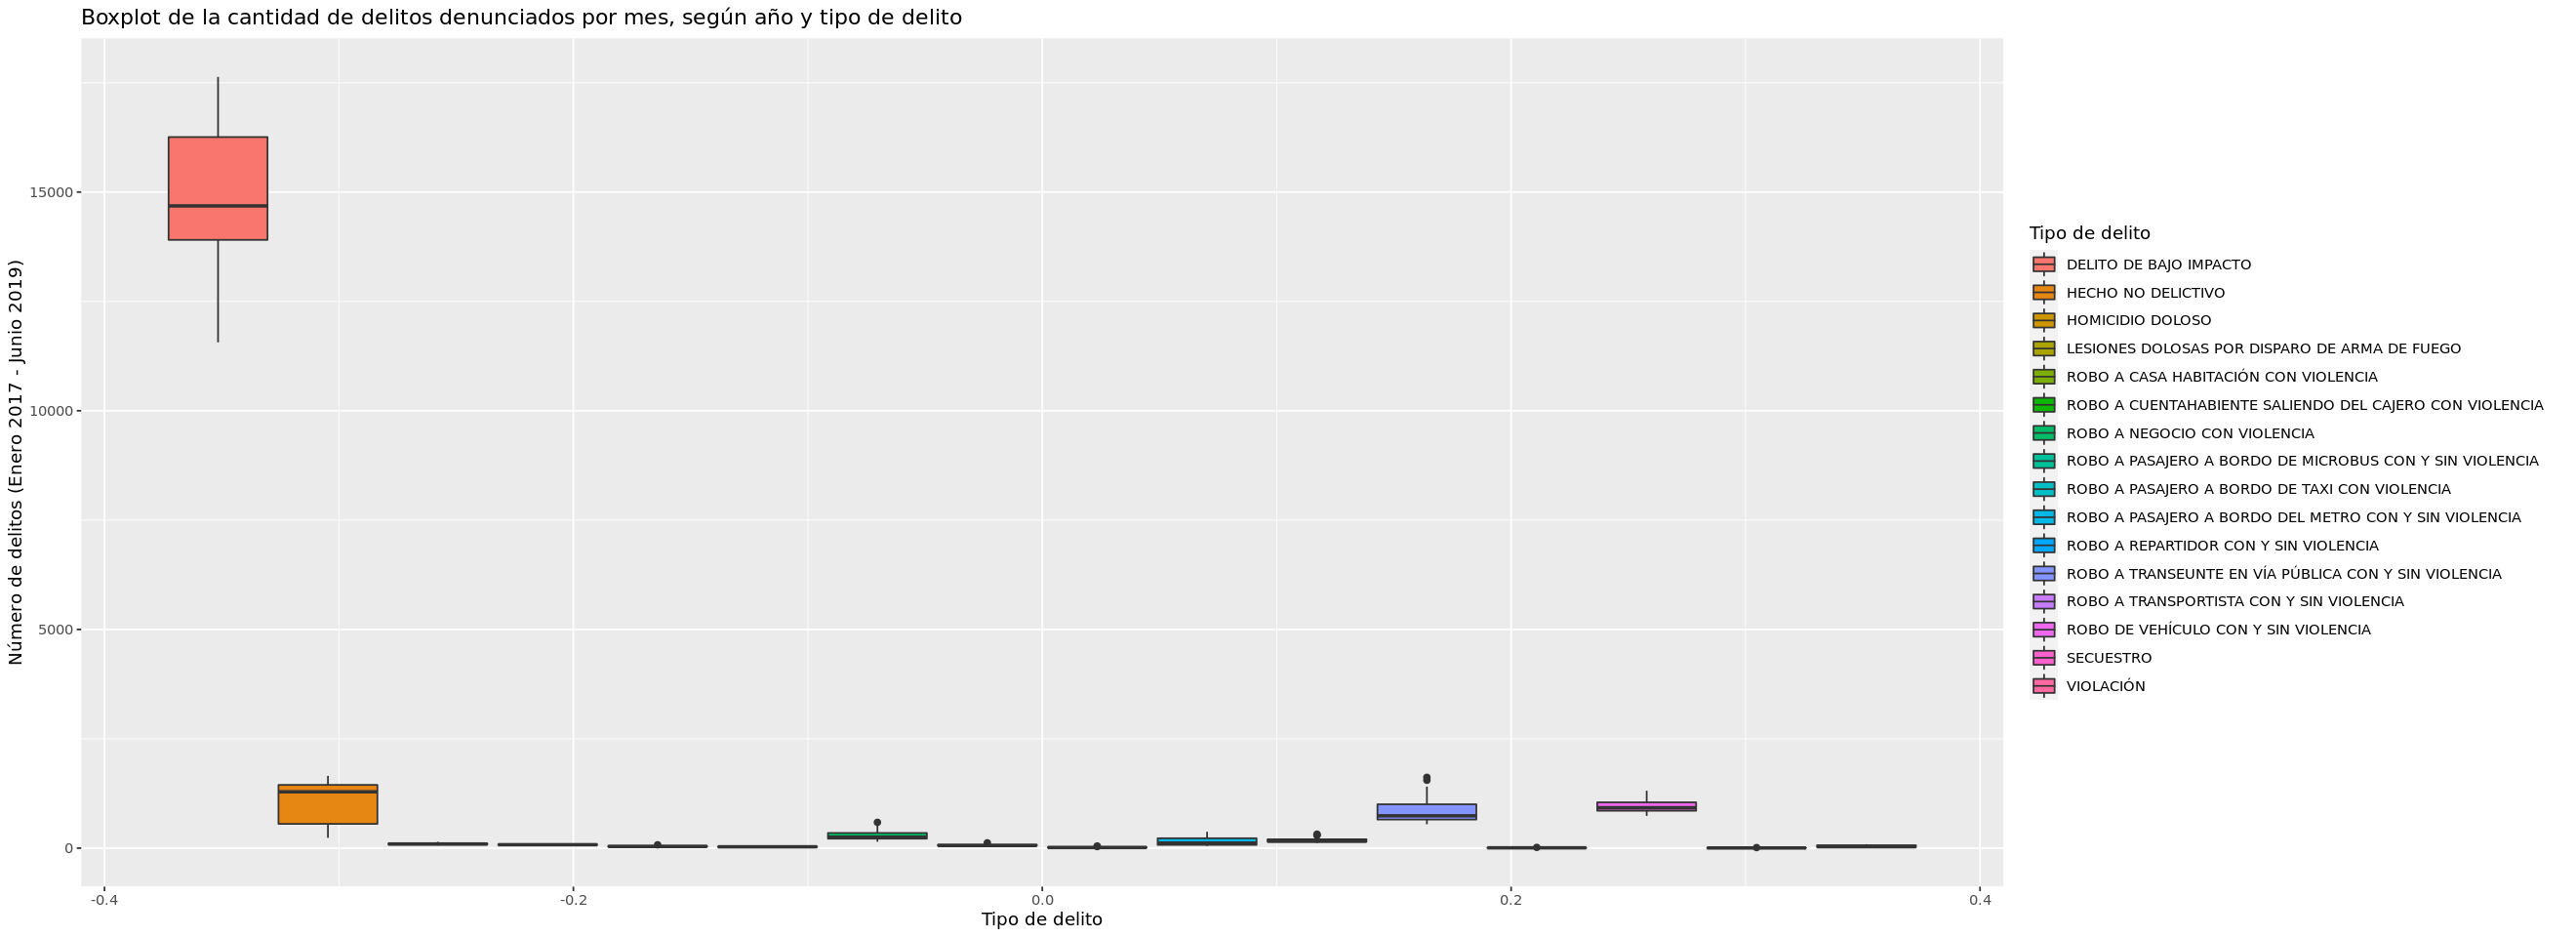

In [21]:
ggplot(d.del,aes(n)) +
    geom_boxplot(aes(fill = categoria_delito)) +
    coord_flip() +
    labs(x = 'Número de delitos (Enero 2017 - Junio 2019)',
         y = 'Tipo de delito',
         title = 'Boxplot de la cantidad de delitos denunciados por mes, según año y tipo de delito',
         fill = 'Tipo de delito')

Con lo anterior se aprecia que los delitos con un mayor número de denuncias son los que se catalogan como _DELITO DE BAJO IMPACTO_.

Por último se puede reproducir el análisis anterior si se consideran sólo mes y año.

In [22]:
(d.mes <- delitos %>%
    group_by(año, mes) %>%
    tally(sort = TRUE)) %>%
    with(sapply(split(n,mes),summary)) %>%
    t() %>%
    format(digits = 2, big.mark = ',') %>%
    as.data.frame() %>%
    rownames_to_column(var = 'Mes')

Mes,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.
<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
January,"15,045","15,822","16,598","16,678","17,494","18,391"
February,"15,643","17,125","18,607","17,636","18,632","18,658"
March,"17,761","18,892","20,022","19,313","20,088","20,155"
April,"16,448","17,260","18,071","18,109","18,940","19,808"
May,"18,897","18,912","18,927","19,691","20,088","21,248"
June,"15,239","16,890","18,542","17,876","19,194","19,847"
July,"18,402","18,818","19,234","19,234","19,651","20,067"
August,"19,226","19,582","19,938","19,938","20,294","20,650"
September,"18,104","18,505","18,906","18,906","19,307","19,708"


Con su respectiva gráfica de boxplot:

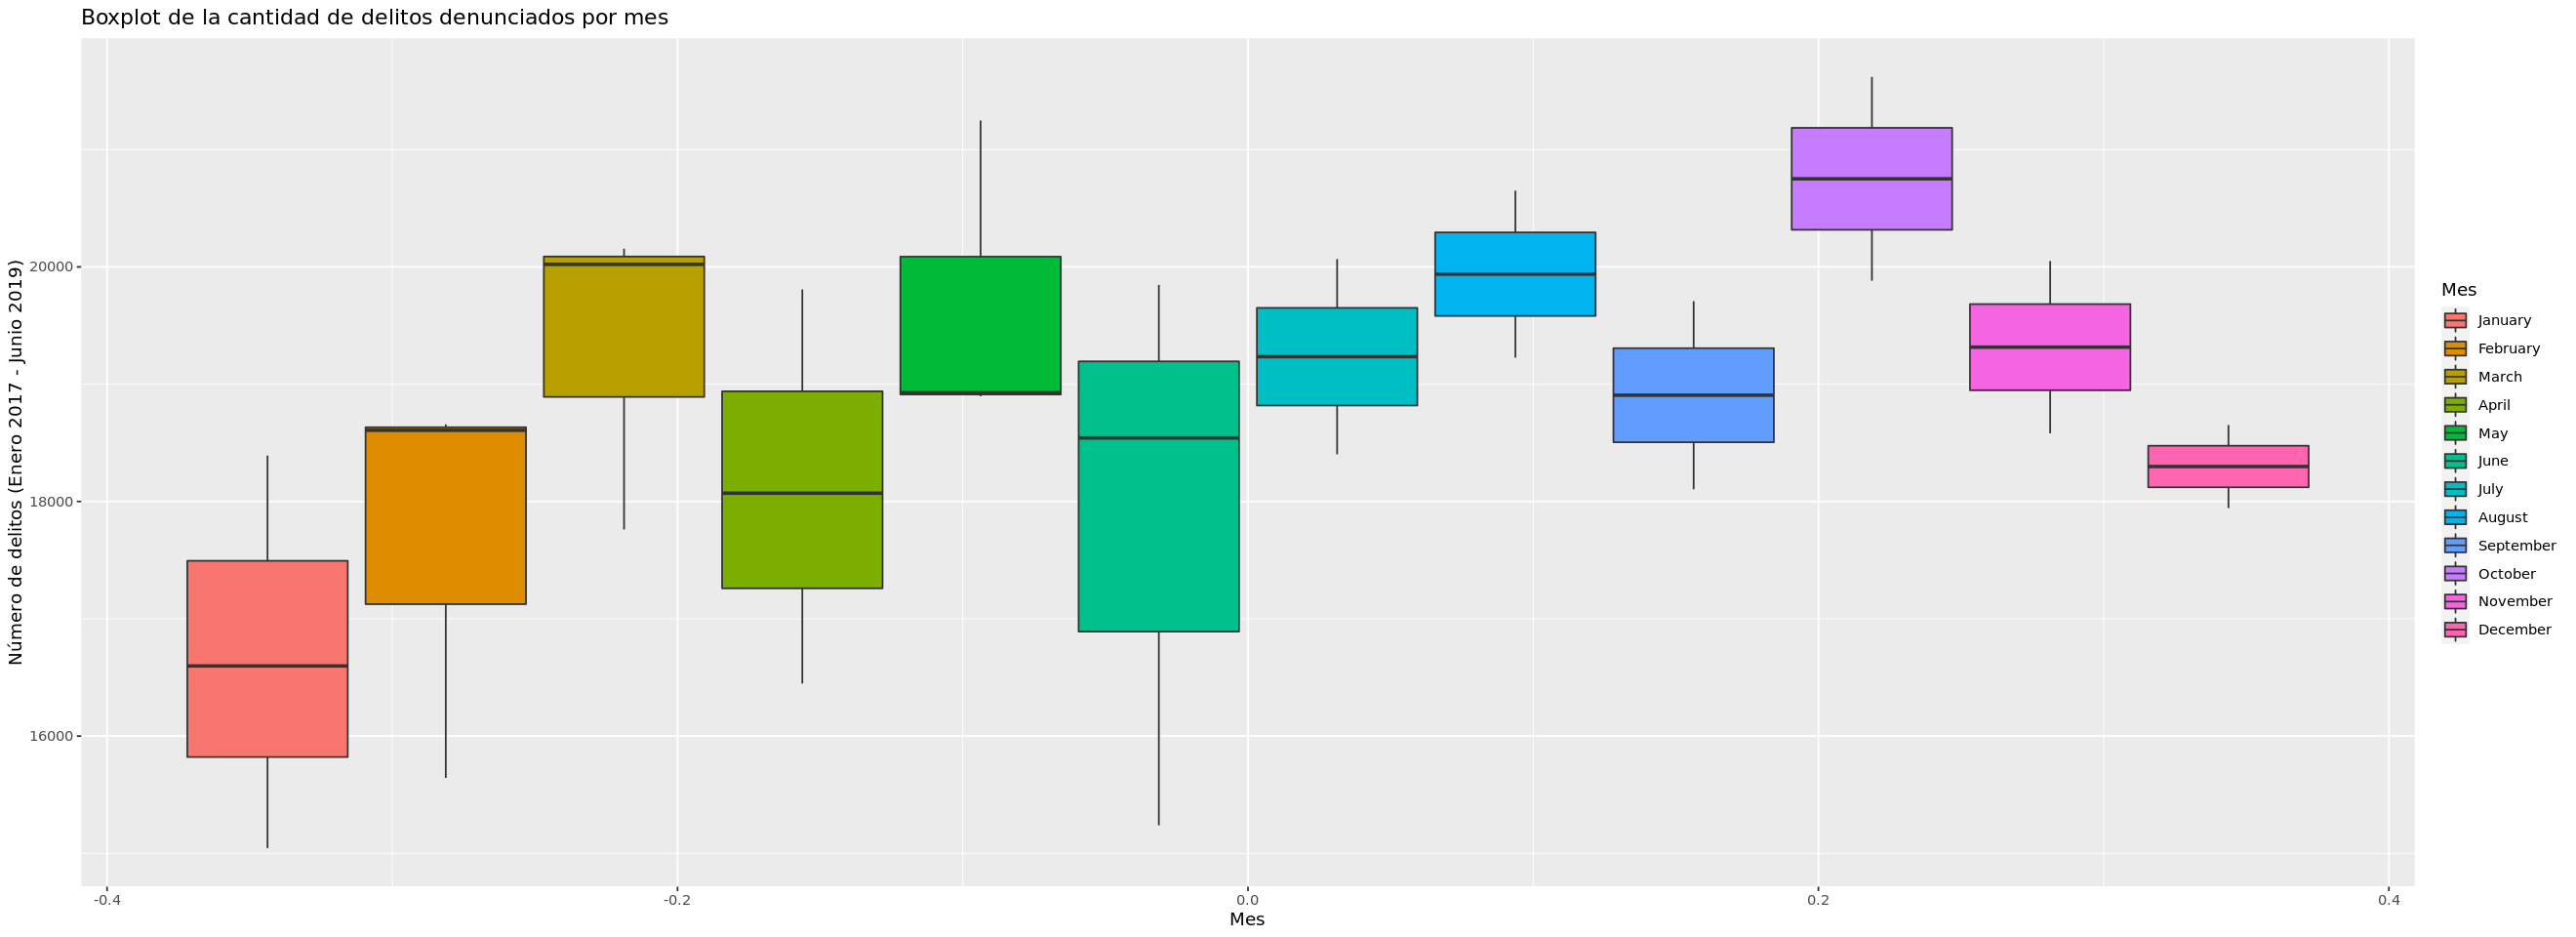

In [24]:
ggplot(d.mes,aes(n)) +
    geom_boxplot(aes(fill = mes)) +
    coord_flip() +
    labs(x = 'Número de delitos (Enero 2017 - Junio 2019)',
         y = 'Mes',
         title = 'Boxplot de la cantidad de delitos denunciados por mes',
         fill = 'Mes')

Con lo anterior se observa que el mes de _Octubre_ es el mes con mayor número de delitos, mientras que el mes con el mayor rango intercuantil es el mes de _Junio_ con un valor de $2,304$ denuncias.

Finalmente, si queremos saber si existe alguna correlación entre el número de delitos denunciados, con el indice de marginación y tamaño de la población usamos la información del _CONAPO_ del 2015, el cuál también incluye el tamaño de población. Por lo tanto se usa la tabla siguiente:

In [25]:
denuncias <- delitos %>%
    group_by(CVE_MUN,alcaldia_hechos) %>%
    tally(sort = TRUE) %>%
    inner_join(marg_index, by = 'CVE_MUN') %>%
    select(CVE_MUN, alcaldia_hechos, n, POB_TOT,IM) %>%
    rename(`Alcaldía` = alcaldia_hechos, `Delitos` = n, `Población`= POB_TOT)
denuncias

CVE_MUN,Alcaldía,Delitos,Población,IM
<dbl>,<fct>,<int>,<int>,<dbl>
9015,CUAUHTEMOC,89016,532553,-1.951
9007,IZTAPALAPA,83399,1827868,-1.627
9005,GUSTAVO A MADERO,56542,1164477,-1.728
9014,BENITO JUAREZ,50386,417416,-2.228
9016,MIGUEL HIDALGO,38128,364439,-2.131
9003,COYOACAN,37835,608479,-1.994
9010,ALVARO OBREGON,37670,749982,-1.779
9017,VENUSTIANO CARRANZA,32850,427263,-1.811
9012,TLALPAN,32148,677104,-1.738


Finalmente la matriz de correlación nos arroja lo siguiente:

In [26]:
cor(denuncias[,3:5])

,Delitos,Población,IM
Delitos,1.0000,0.71309,-0.41621
Población,0.7131,1.00000,-0.01791
IM,-0.4162,-0.01791,1.00000


Con lo cual observamos que existe una gran asociación lineal entre el tamaño de la población y el número de delitos denunciados ($0.7131$), pero no así entre el índice de marginación y el número de delitos denunciados, incluso esta es negativa ($-0.41621$), mientras que la asociación lineal entre el tamaño de la población y el indice de marginación es débil ($-0.01791$).

Lo anterior se puede apreciar en la gráfica siguiente.

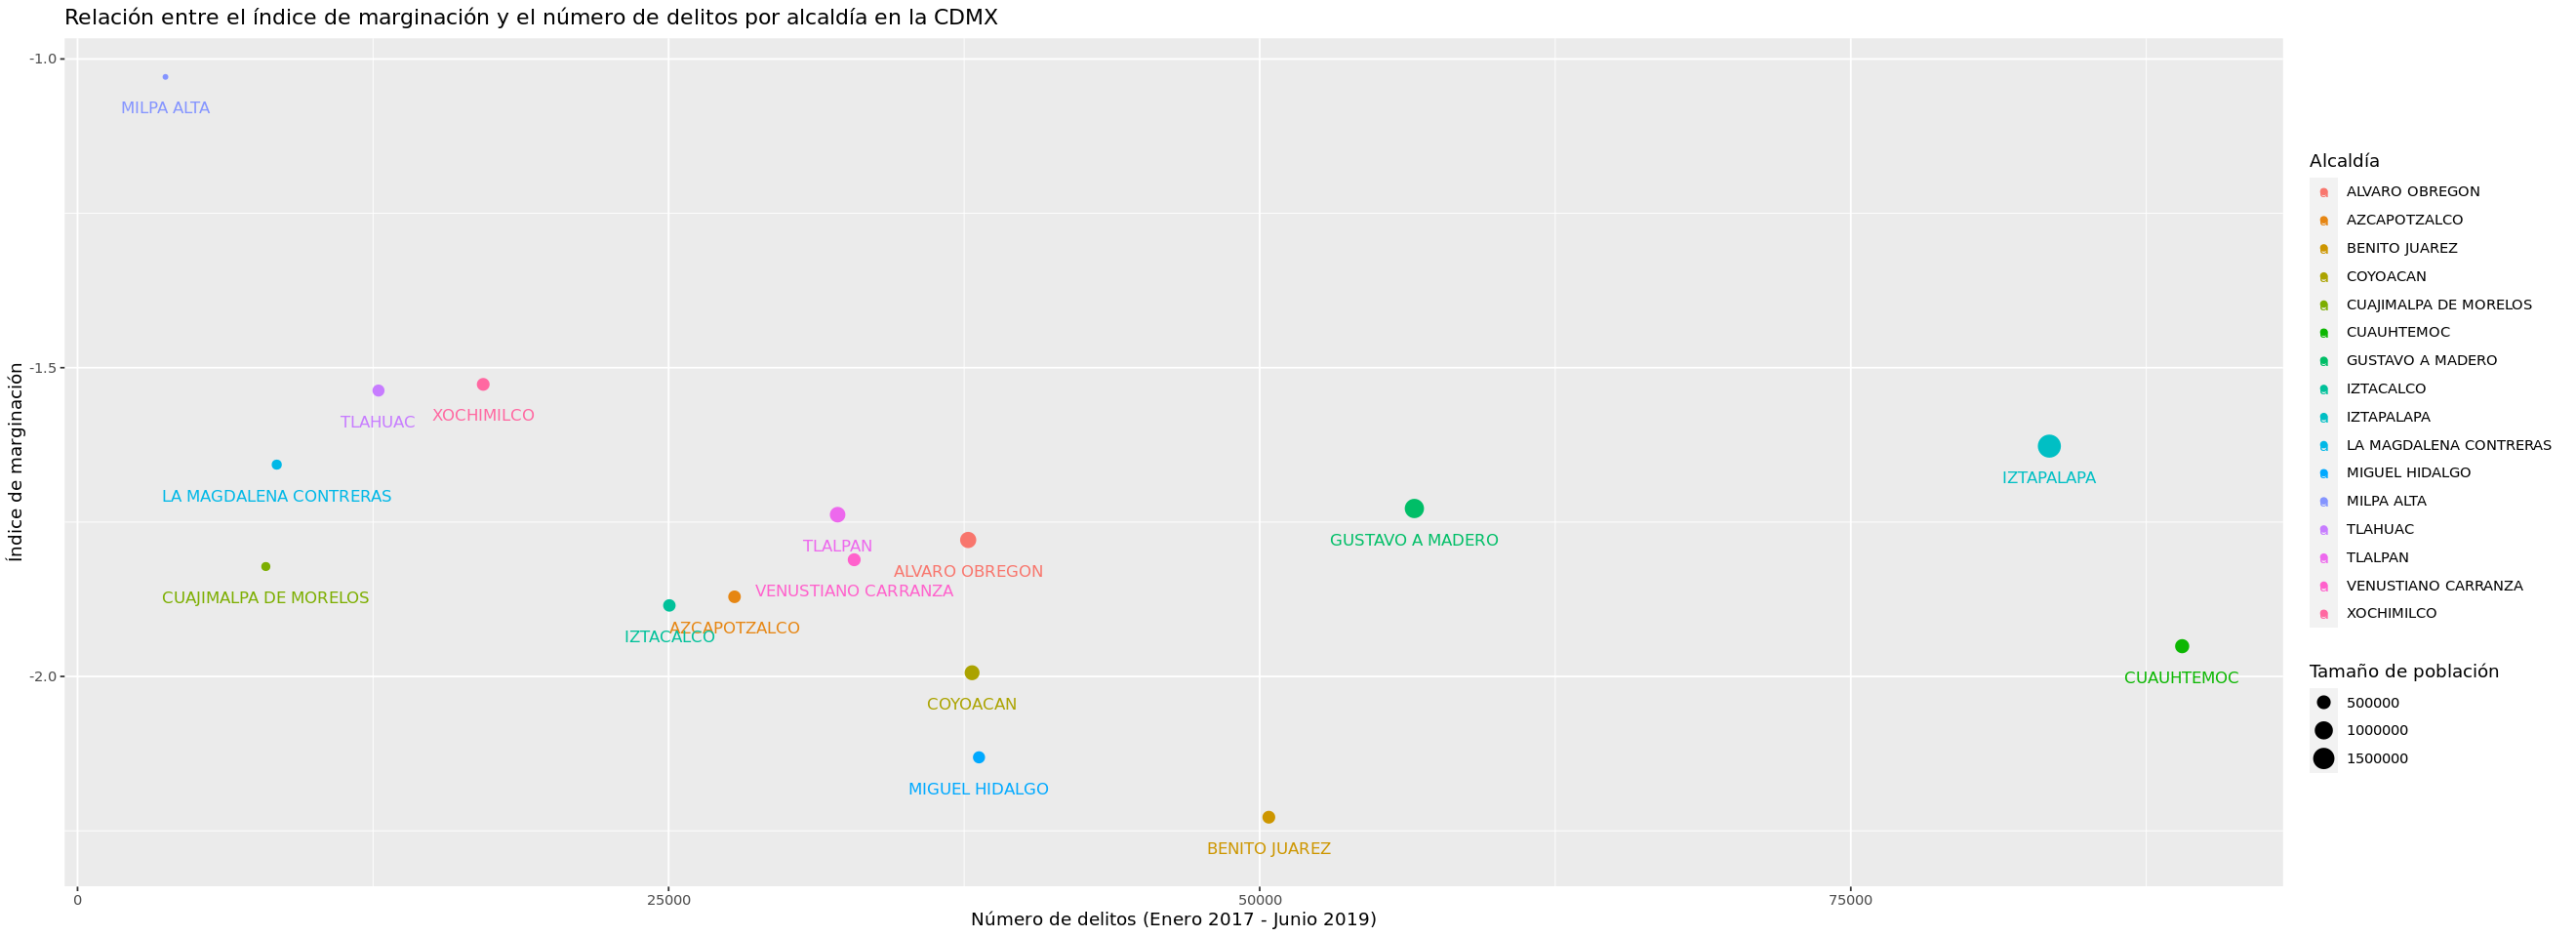

In [27]:
denuncias %>%
    ggplot(aes(x = Delitos, y = IM, color = Alcaldía, size = Población, label = Alcaldía)) +
    geom_point() +
    geom_text(aes(y = IM-0.05, label = Alcaldía), size = 3.5) +
    labs(x = 'Número de delitos (Enero 2017 - Junio 2019)',
         y = 'Índice de marginación',
         title = 'Relación entre el índice de marginación y el número de delitos por alcaldía en la CDMX',
         size = 'Tamaño de población')

Para más información puede revisar el archivo: _[analisis_descriptivo.ipynb](analisis_descriptivo.ipynb)_.

## Inferencia

In [37]:
install.packages("forecast")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘fracdiff’, ‘lmtest’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’




Para el análisis de inferencia se requirieron los paquetes siguientes:

In [38]:
library(dplyr)
library(lubridate)
library(magrittr)
library(readr)
library(forecast)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



Con el objetivo de subir un gran volumen de datos al repositorio de GitHub, los datos fueron filtrados y guardados en formato .rds. El filtro permite conservar únicamente los delitos identificados dentro del perímetro de la Ciudad de México, así como las columnas que se muestran a continuación:

In [30]:
data <- readRDS("datos_delitos.rds")
head(data)

fecha_hechos,categoria_delito,alcaldia_hechos,longitud,latitud
<dttm>,<chr>,<chr>,<dbl>,<dbl>
2017-11-01 16:40:00,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA,IZTACALCO,-99.11,19.40
2018-05-16 16:00:00,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,IZTAPALAPA,-99.04,19.32
2018-05-21 20:40:00,DELITO DE BAJO IMPACTO,IZTACALCO,-99.11,19.39
2018-05-22 06:20:00,DELITO DE BAJO IMPACTO,BENITO JUAREZ,-99.18,19.38
2017-11-01 17:15:00,DELITO DE BAJO IMPACTO,CUAUHTEMOC,-99.13,19.43
2017-11-01 09:00:00,DELITO DE BAJO IMPACTO,CUAUHTEMOC,-99.17,19.41


Para realizar un ejemplo de series de tiempo con los datos, se conservan los delitos identificados antes del año 2019. Posteriormente se realiza un conteo de delitos cometidos de manera diaria. Los primeros $10$ registros se muestran a continuación

In [33]:
data %<>% mutate(fecha = date(fecha_hechos), mes = month(fecha_hechos, label = T)) %>% filter(fecha < '2019-01-01')
delitos <- data %>% group_by(fecha) %>% tally() %>% tibble %>% mutate(dia_semana = wday(fecha, label = T, abbr = F))
sample_n(delitos, 10)

fecha,n,dia_semana
<date>,<int>,<ord>
2017-01-09,534,Monday
2017-11-24,659,Friday
2017-03-26,440,Sunday
2018-09-02,505,Sunday
2018-10-01,782,Monday
2017-11-30,651,Thursday
2018-04-12,662,Thursday
2018-12-31,415,Monday
2017-03-05,427,Sunday


### Serie de tiempo

A continuación se presenta un gráfico con la información de delitos denunciados por día.

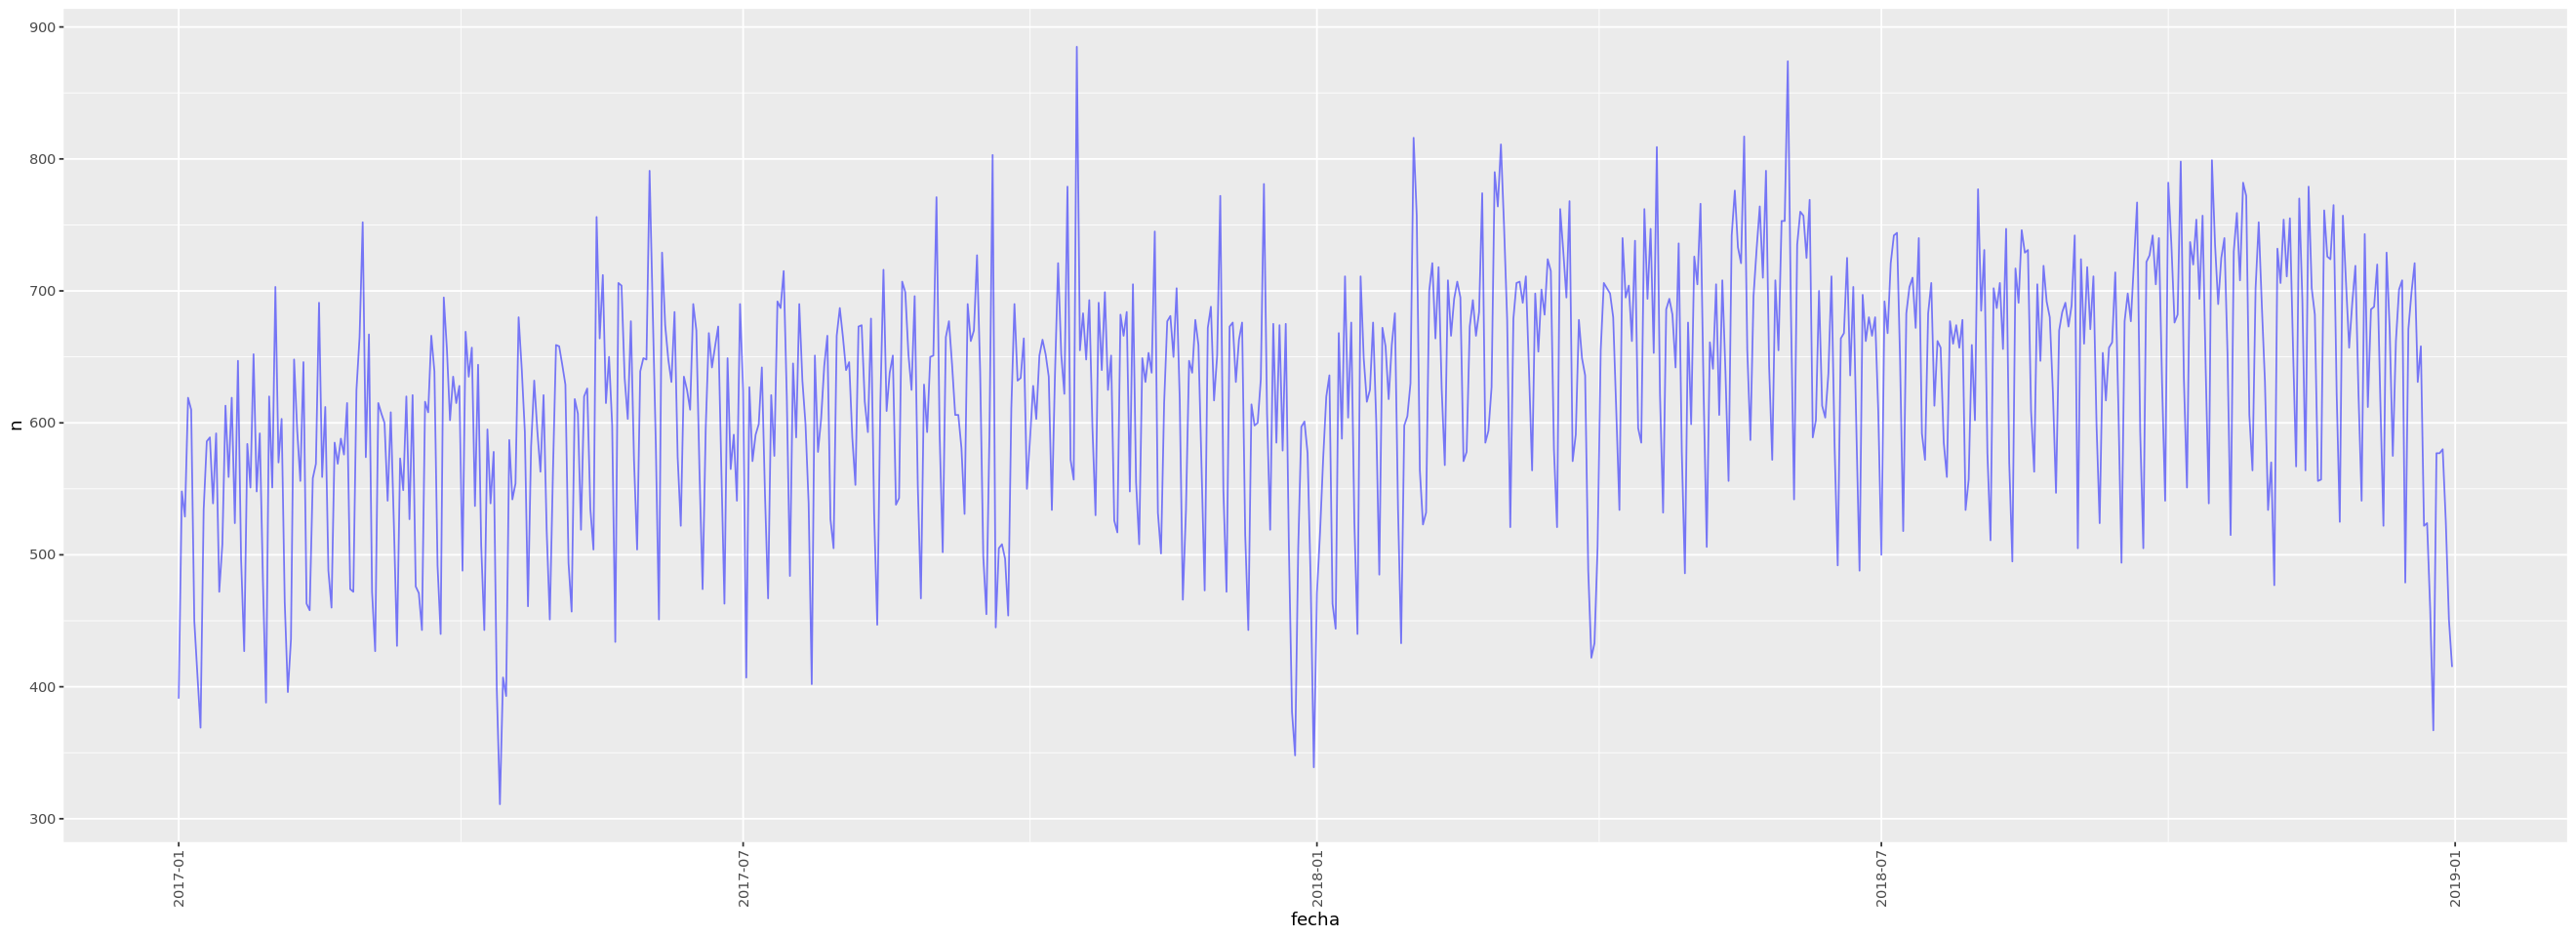

In [34]:
plot <- ggplot(delitos, aes(x = fecha, y = n, label = dia_semana)) + 
    geom_line(color = "blue", 
              alpha = 0.5, position = position_dodge(0.8)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

plot

#### Modelo estacional

Para predecir el número de delitos en la segunda mitad del año 2018, se analizan los datos entre el primero de enero del 2017 y la primera mitad del año 2018. Posteriormente, se ajustan distintos modelos para identificar cual de ellos ajusta mejor a los datos. La medida de error usada es la raíz de error cuadrático medio **RMSE**.

Modelo 1 (ETS):

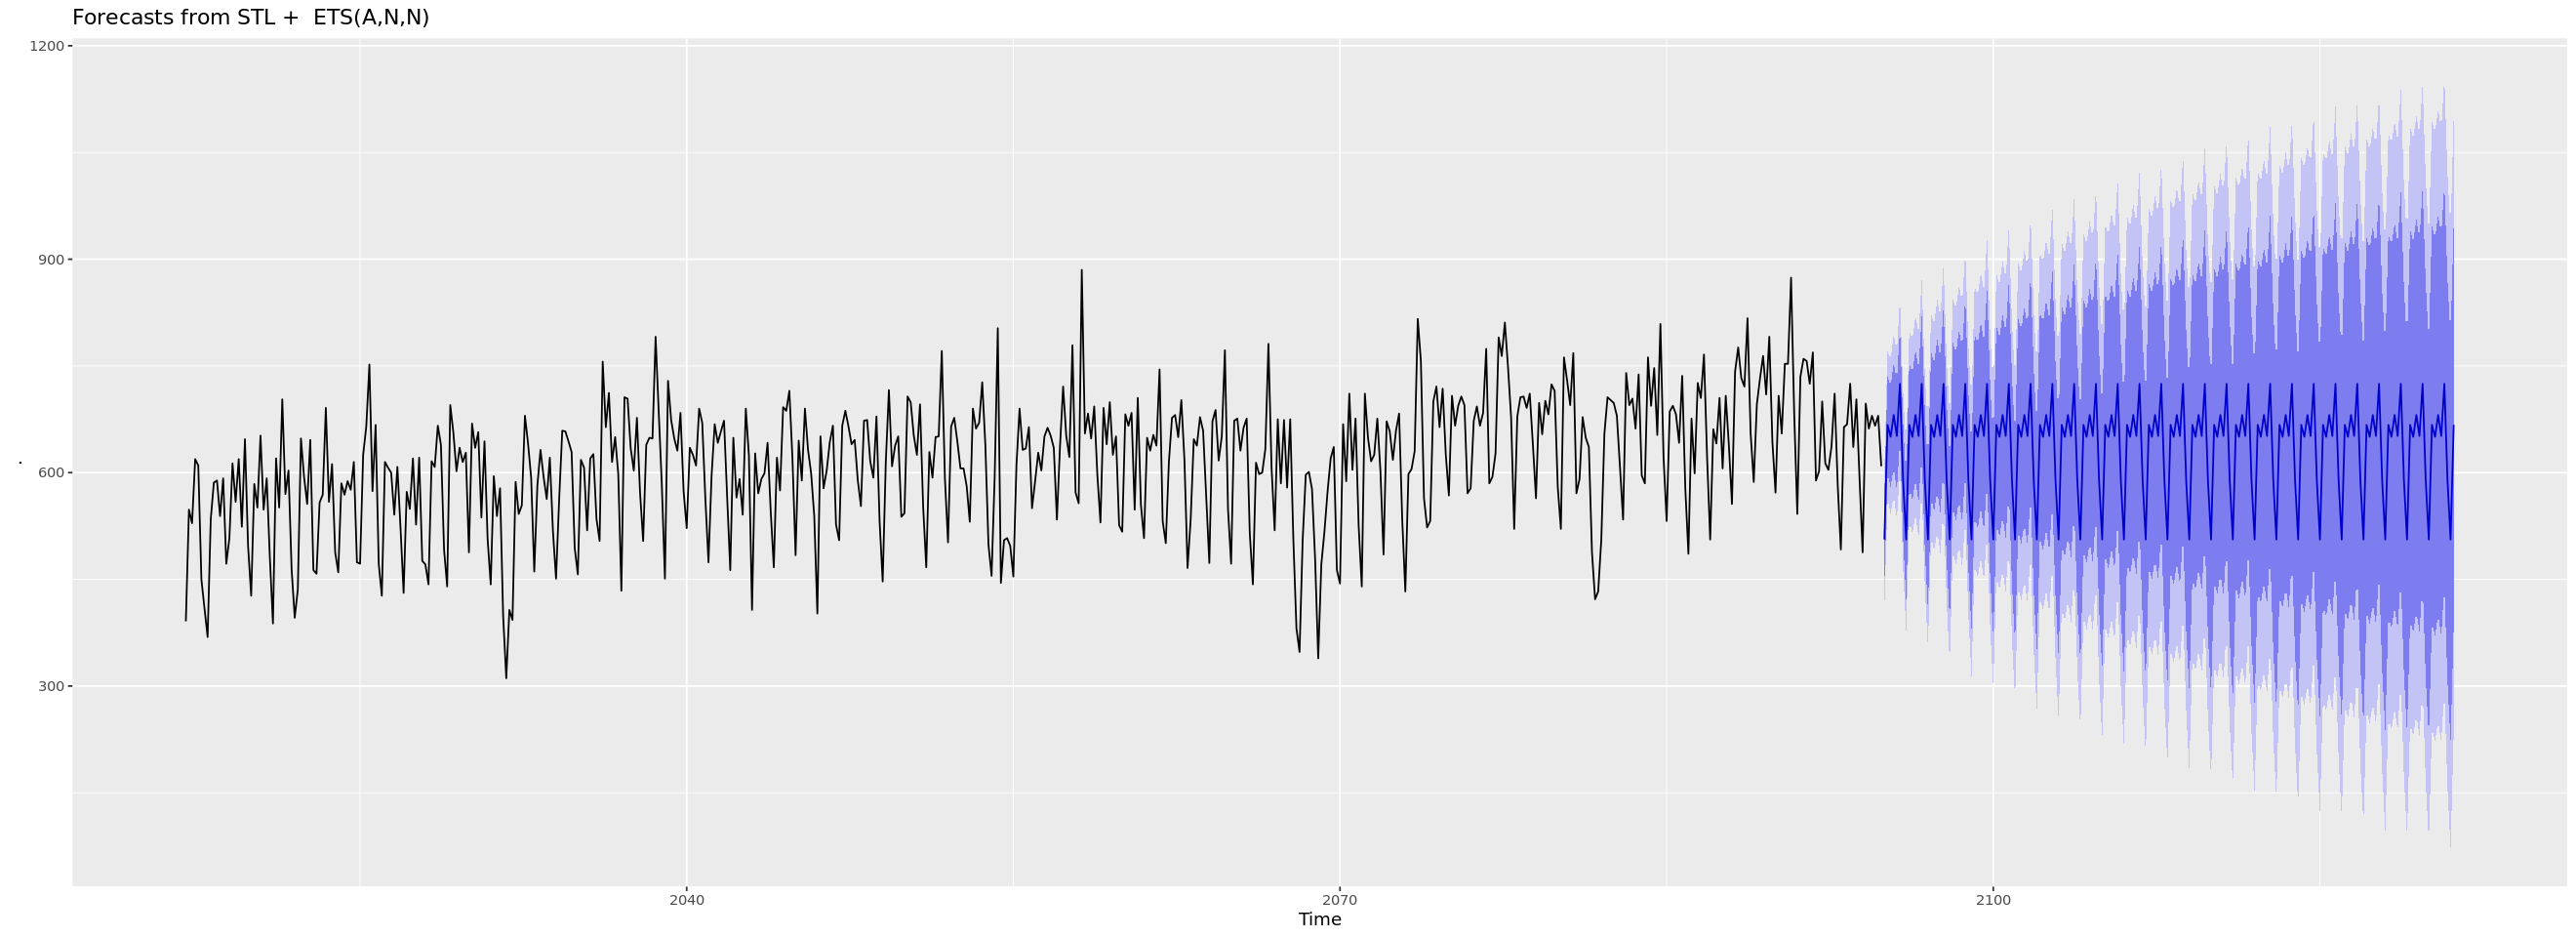

In [39]:
first_day <- pull(head(delitos,1), fecha)

y <- msts(delitos[delitos$fecha < '2018-07-01',]$n, seasonal.periods = c(7), start = c(2017, 1))
n = 184
mod1 <- y %>% stlf(h = n, method = "ets") 
mod1 %>% autoplot()

Modelo 2 (Arima):

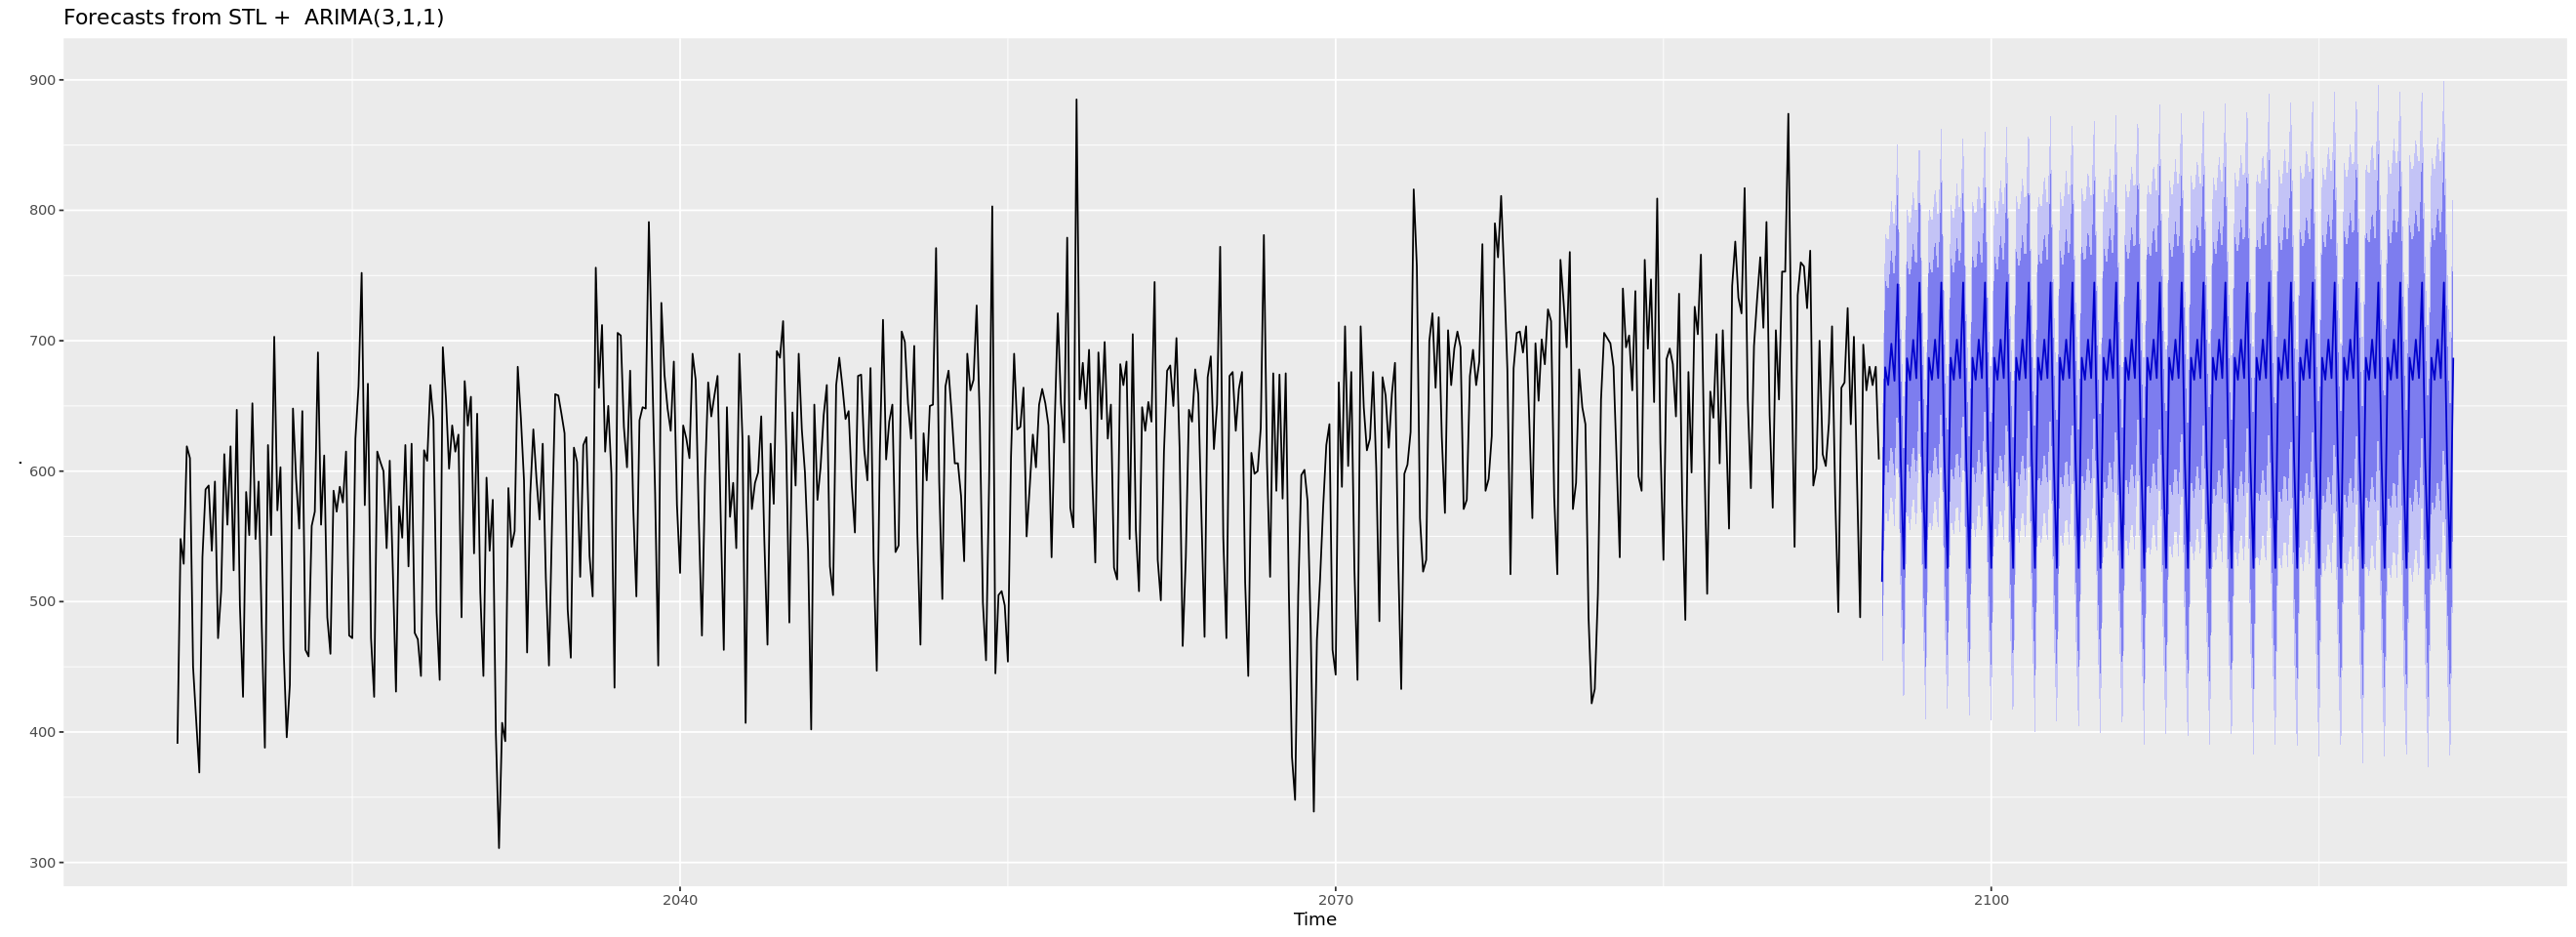

In [40]:
mod2 <- y %>% stlf(h = n, method = "arima") 
mod2 %>% autoplot()

Modelo 3 (Random Walk):

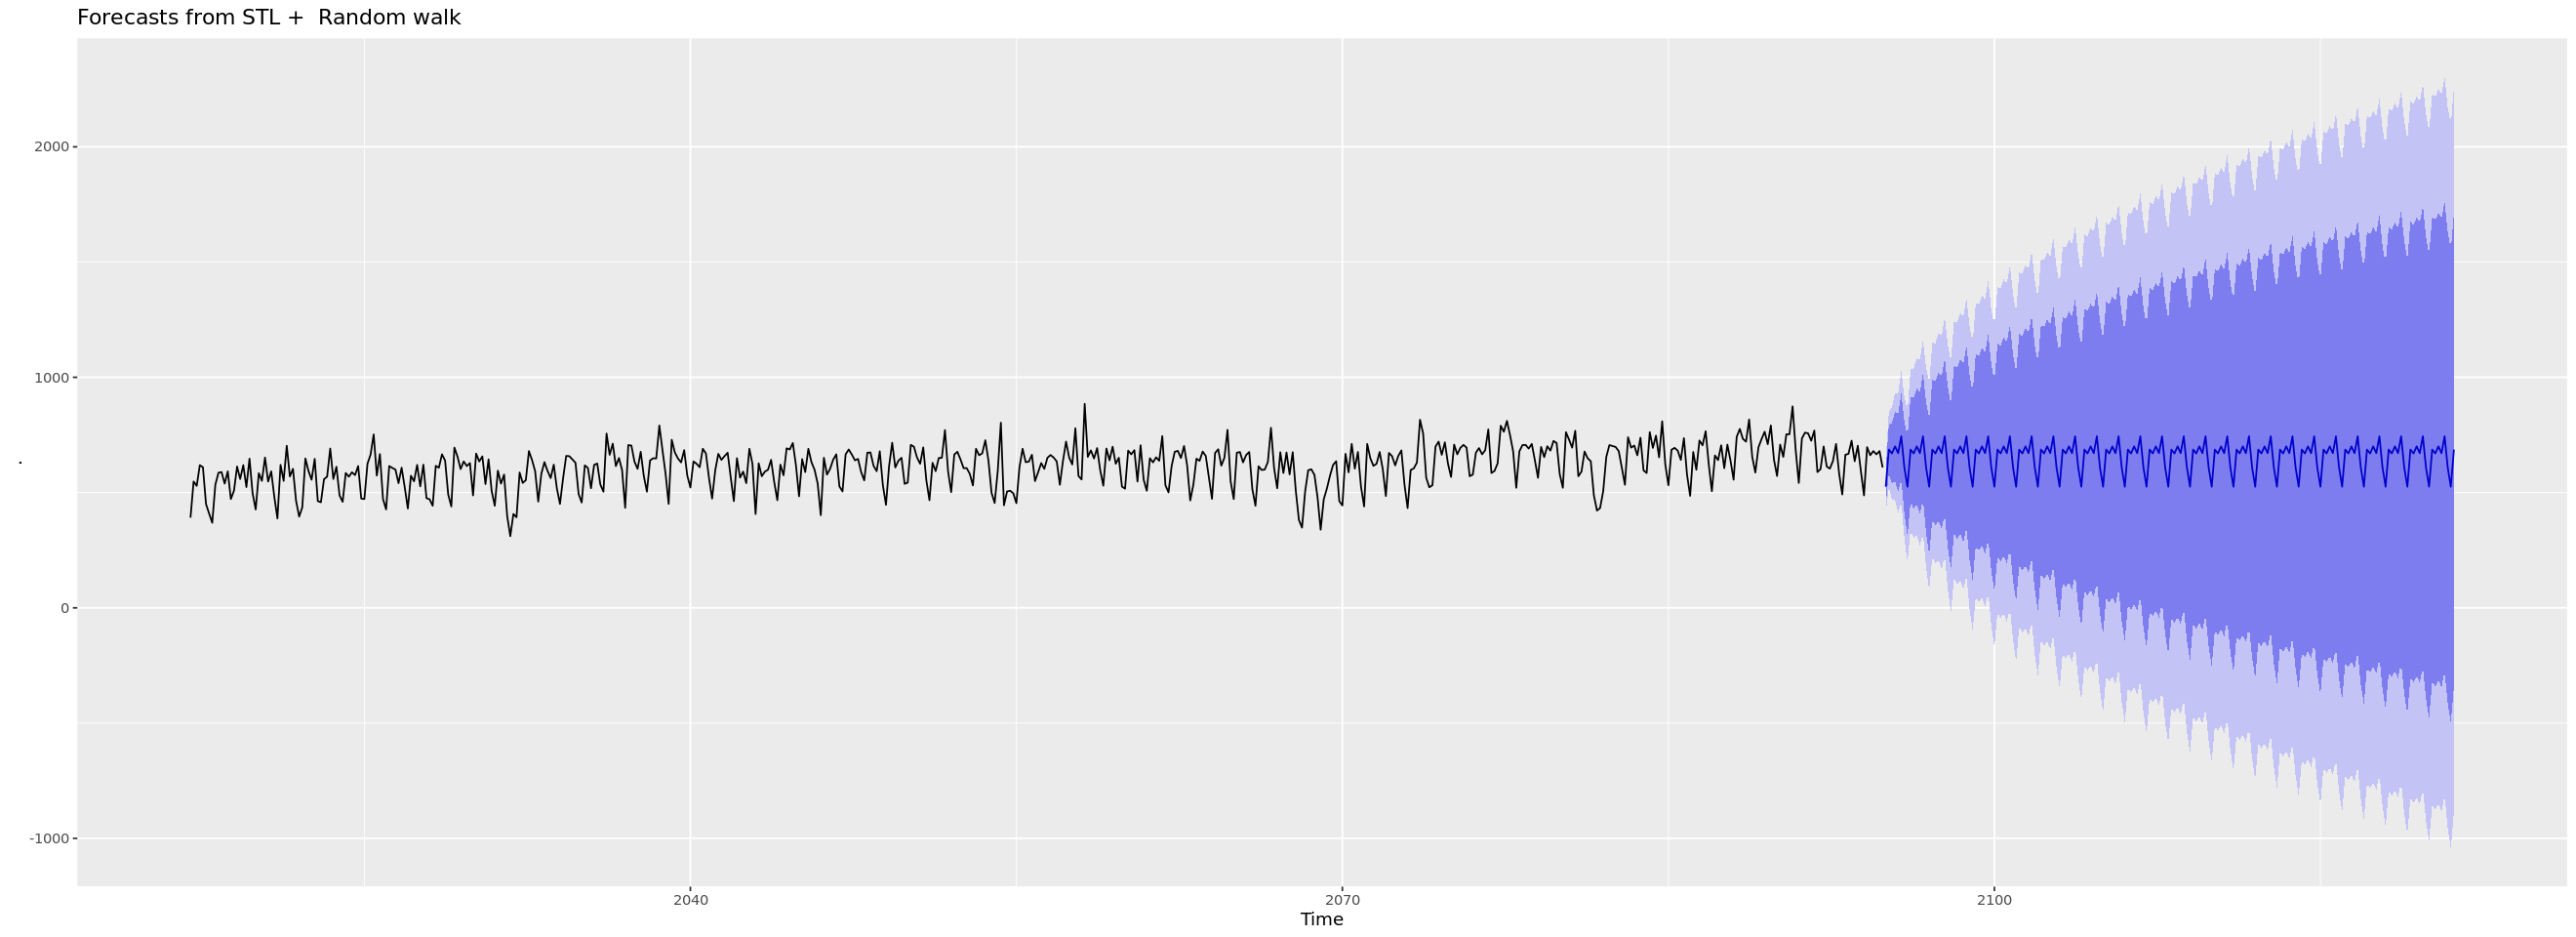

In [42]:
mod3 <- y %>% stlf(h = n, method = "naive") 
mod3 %>% autoplot()

Modelo 4 (Random Walk with drift):

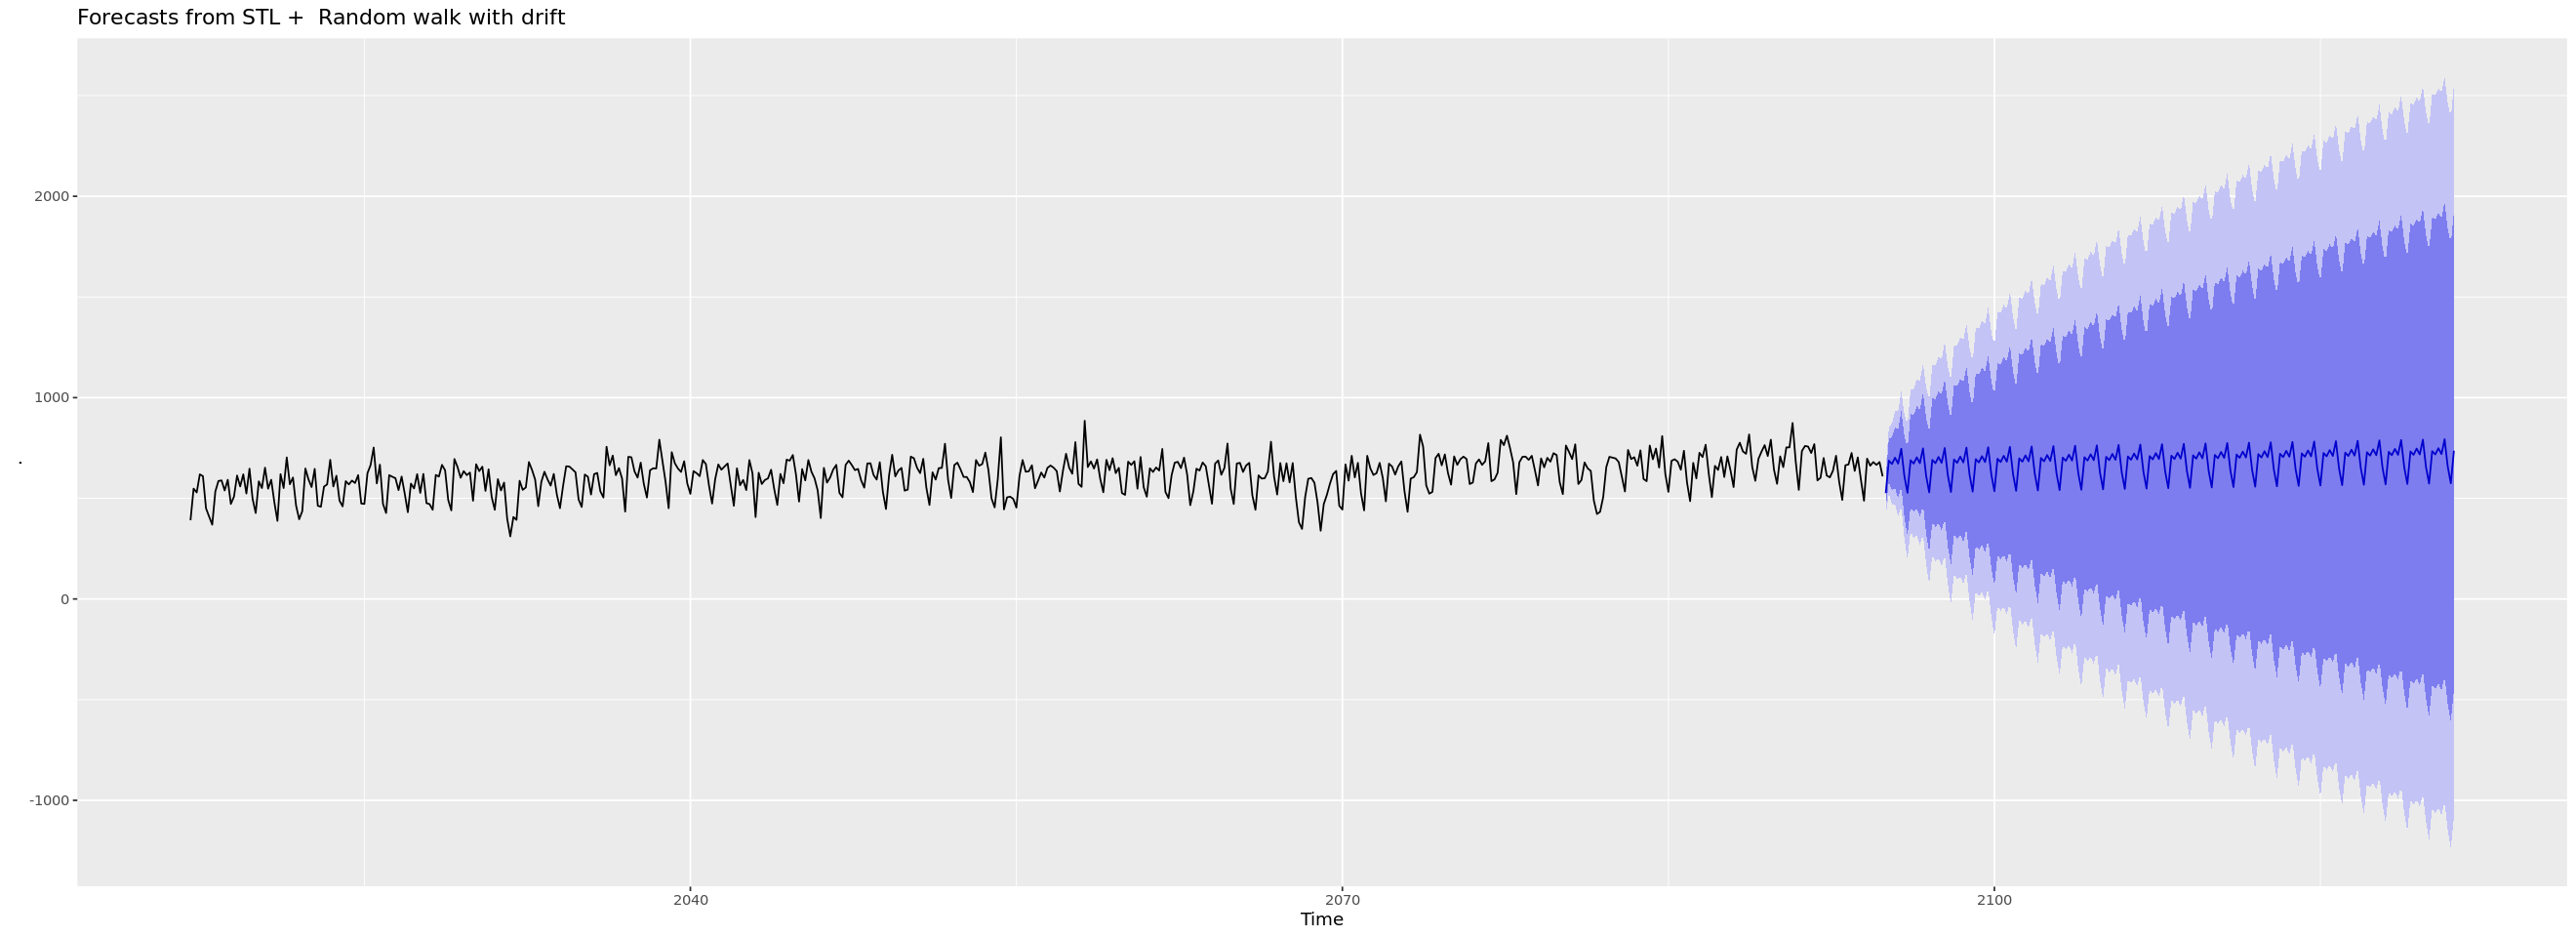

In [43]:
mod4 <- y %>% stlf(h = n, method = "rwdrift") 
mod4 %>% autoplot()

Modelo 5:

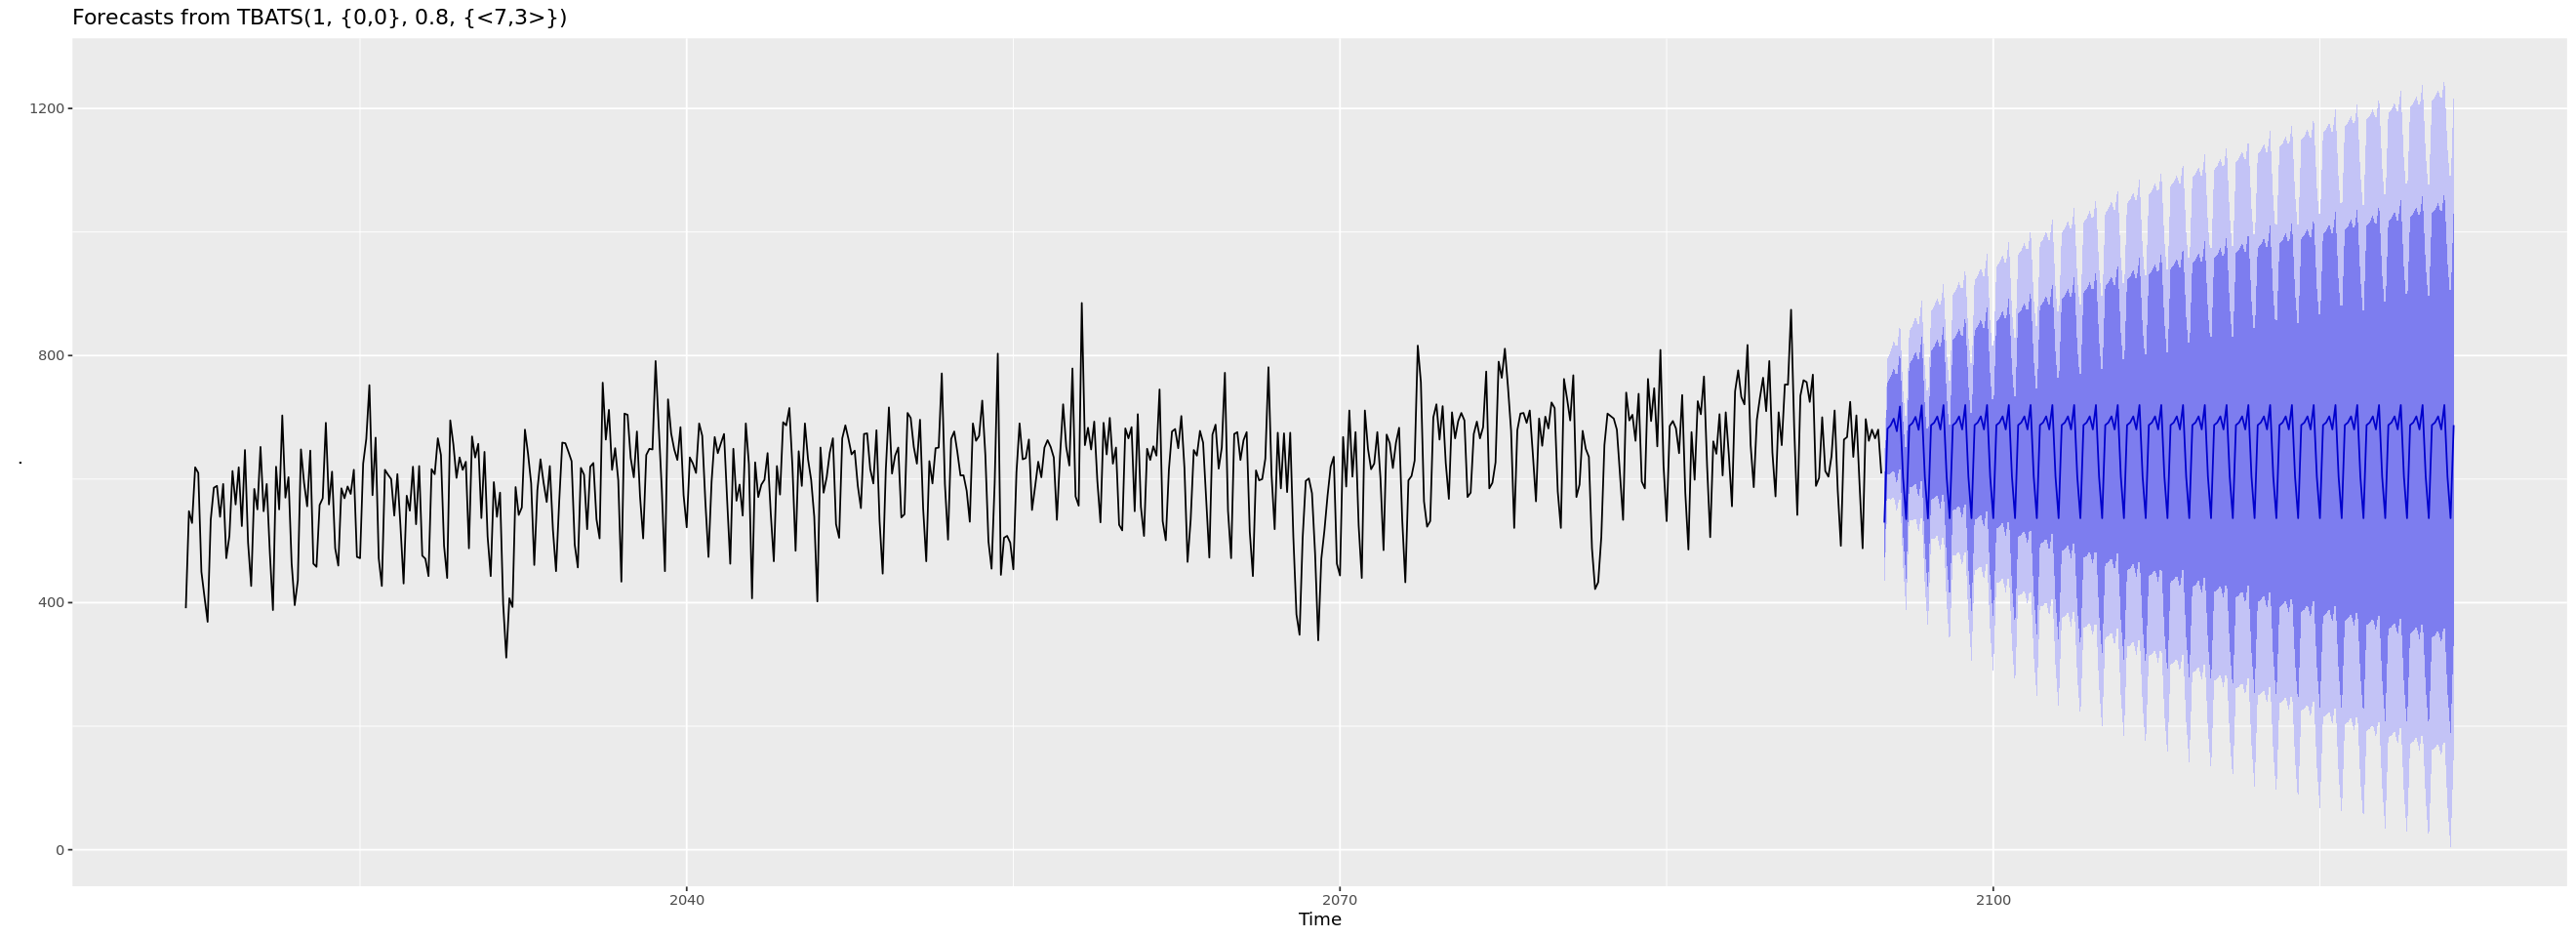

In [44]:
fit5 <- y %>% tbats()
mod5 <- forecast(fit5, h = n, lambda = "auto")
mod5 %>% autoplot()

A continuación, se comparan las distintas medidas de error entre los diferentes modelos. Como se mencionó anteriormente, el error usado para determinar el mejor modelo será el __RMSE__.

In [45]:
resultados <- rbind.data.frame(accuracy(mod1),accuracy(mod2),accuracy(mod3),accuracy(mod4),accuracy(mod5)) %>% round(3) 
row.names(resultados) <- c("ets","arima","naive","rwdrift","auto")
resultados

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ets,0.716,50.44,37.42,-0.524,6.365,0.661,0.070
arima,2.946,49.46,35.95,-0.196,6.102,0.635,-0.007
naive,0.271,59.13,44.73,-0.457,7.555,0.791,-0.424
rwdrift,0.000,59.13,44.74,-0.502,7.558,0.791,-0.424
auto,3.865,54.28,38.57,-0.159,6.584,0.682,0.007


el modelo _ARIMA_ es seleccionado como el modelo que mejor ajusta a los datos. El _RMSE_ asociado es de $49.4$, sin embargo, dicho error corresponde al ajuste realizado y a los datos observados. Para obtener un _RMSE_ predictivo, es necesario realizar el cálculo del error entre las predicciones realizadas y los datos observados que no formaron parte del ajuste del modelo. A continuación se crea la tabla que permite comparar ambas columnas.

Adicionalmente, se agregan las columnas con el límite inferior y superior del intervalo de confianza al $95\%$.

In [46]:
comp = data.frame(fecha = date('2018-07-01') + 0:(n-1), 
                  real = delitos[delitos$fecha %in% (date('2018-07-01') + 0:(n-1)),]$n,
                  lower = round(mod2$lower[1:n,2]),
                  prediction = round(mod2$mean[1:n]),
                  upper = round(mod2$upper[1:n,2]))
comp %<>% mutate(sq_diff = (prediction - real)^2)

head(comp,10)

,fecha,real,lower,prediction,upper,sq_diff
,<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2018-07-01,500,418,515,613,225
2,2018-07-02,692,576,680,783,144
3,2018-07-03,668,558,666,774,4
4,2018-07-04,721,587,698,808,529
5,2018-07-05,742,557,669,781,5329
6,2018-07-06,744,630,743,856,1
7,2018-07-07,647,494,608,722,1521
8,2018-07-08,518,411,525,640,49
9,2018-07-09,683,572,687,801,16


El RMSE calculado es:

In [47]:
comp$sq_diff %>% mean() %>% sqrt() %>% round()

[1] 61

#### Visualización de predicción de delitos en la Ciudad de México

A continuación se presenta el modelo predictivo con intervalos de confianza y se contrasta con los datos reales:

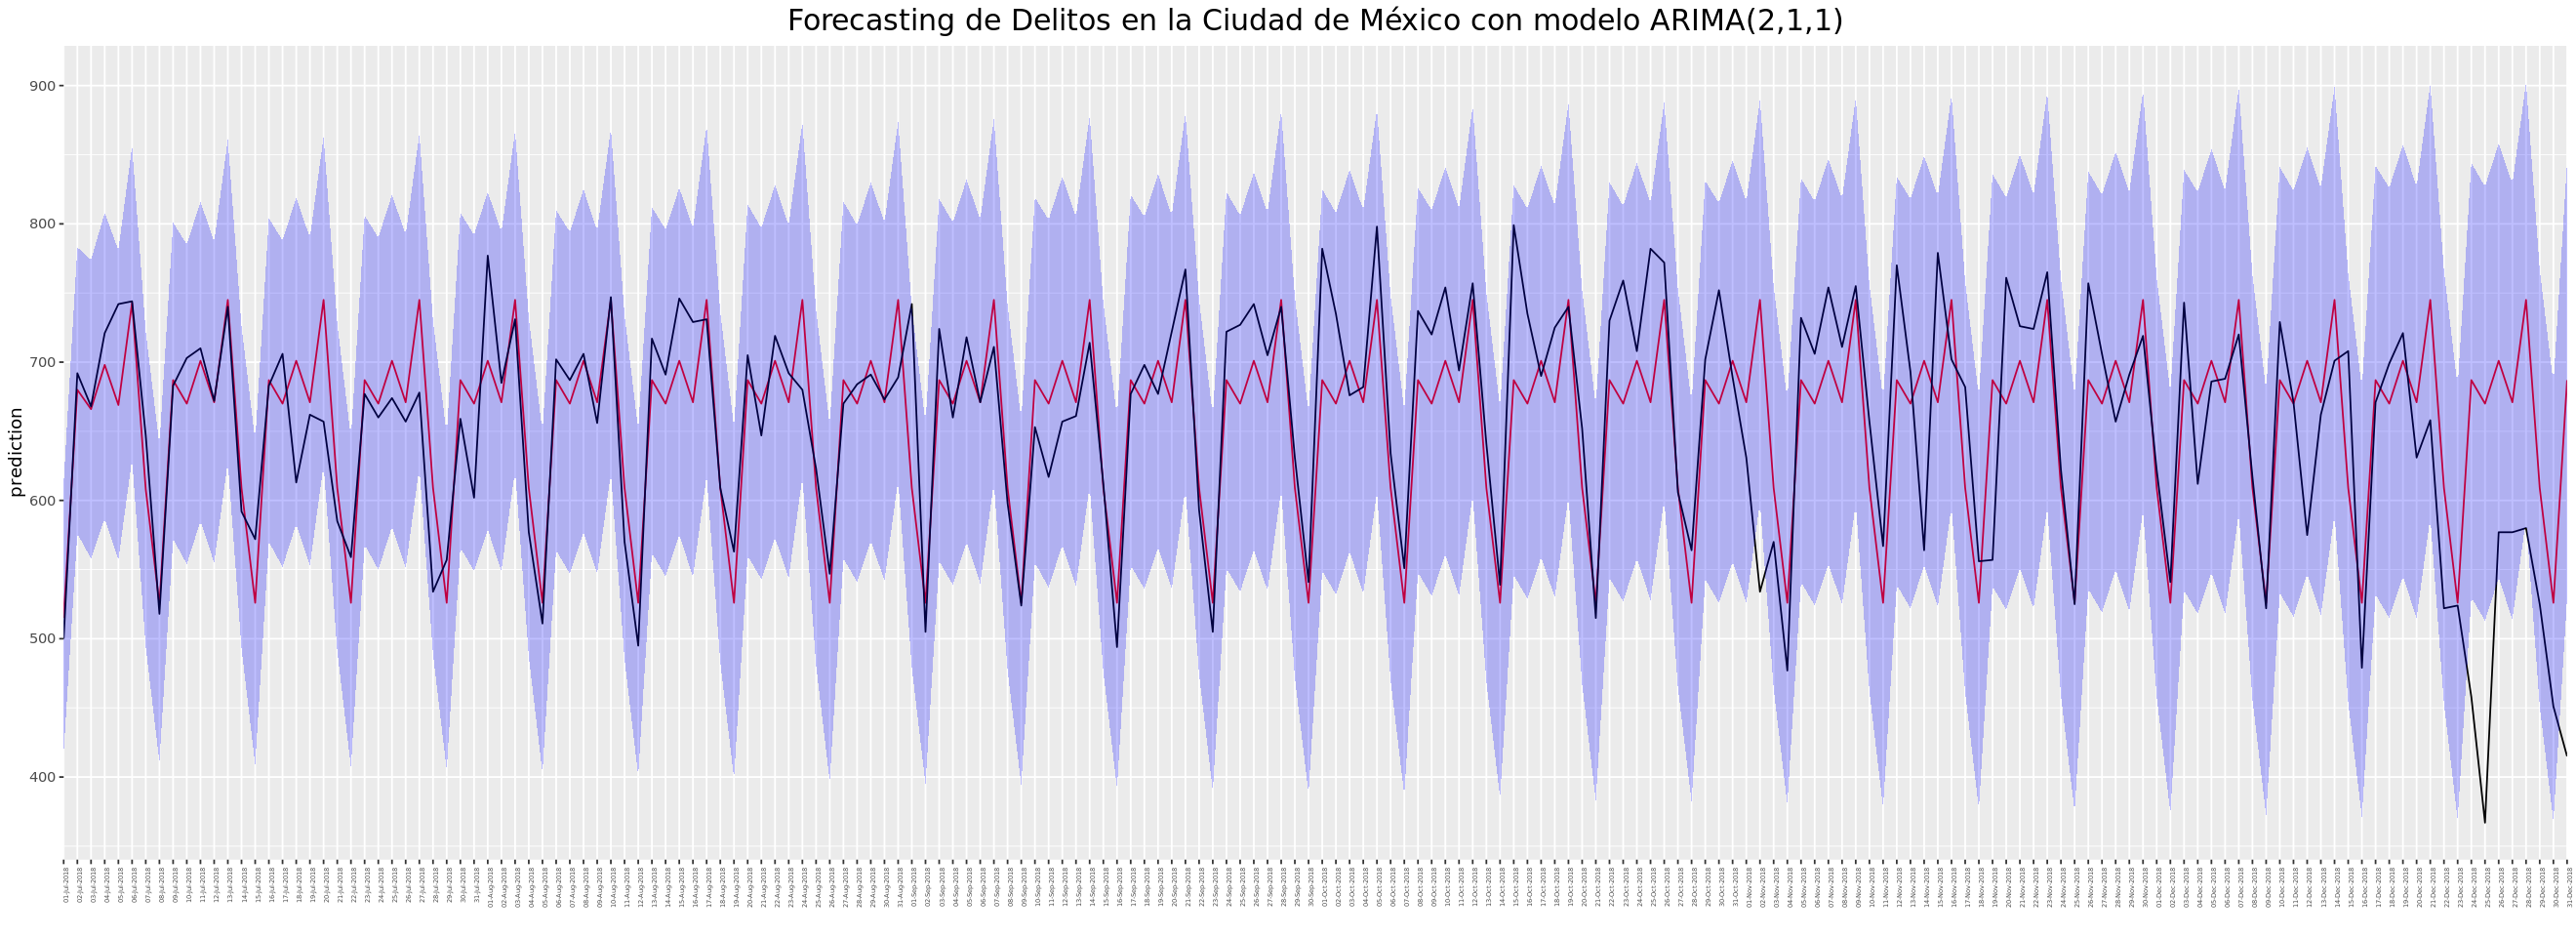

In [48]:
forecast_plot <- ggplot(data = comp, aes(x = fecha)) +
    geom_line(aes(y = prediction), col = "red") +
    geom_line(aes(y = real), col = "black") +
    geom_ribbon(aes(ymin = lower, ymax = upper),
                alpha = 0.25, fill = "blue") +
    scale_x_date(name ='', breaks = '1 day', minor_breaks = '1 day', 
                 labels = scales::date_format("%d-%b-%Y"), expand = c(0,0)) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 4), plot.title = element_text(size=18, hjust = 0.5)) +
    ggtitle("Forecasting de Delitos en la Ciudad de México con modelo ARIMA(2,1,1)")

forecast_plot

A continuación se calcula la proporción en la que el intervalo de confianza cubre al número real de delitos reportados.

In [49]:
conf = comp %>% 
mutate(flag = ifelse(and(real > lower, real < upper),1,0)) 

conf %>% summarise(confidence = mean(flag))

confidence
<dbl>
0.9674


Se observa que en su mayoría, los días que el intervalo no cubre al valor real de delitos es porque se trata de un día festivo. En esos días, la siniestralidad es significativamente menor a la estimada bajo condiciones normales.

In [51]:
conf %>% filter(flag == 0)

fecha,real,lower,prediction,upper,sq_diff,flag
<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-09-01,742,479,609,739,17689,0
2018-11-02,534,599,745,890,44521,0
2018-12-24,458,530,687,844,52441,0
2018-12-25,367,513,670,827,91809,0
2018-12-28,580,587,745,902,27225,0
2018-12-31,415,529,687,845,73984,0


#### Predicciones diarias

A continuación, se muestra una tabla con las primeras $6$ predicciones diarias de la segunda mitad del año 2018.

In [53]:
head(comp)

,fecha,real,lower,prediction,upper,sq_diff
,<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2018-07-01,500,418,515,613,225
2,2018-07-02,692,576,680,783,144
3,2018-07-03,668,558,666,774,4
4,2018-07-04,721,587,698,808,529
5,2018-07-05,742,557,669,781,5329
6,2018-07-06,744,630,743,856,1


Para más información puede revisar el archivo: _[time_series.ipynb](time_series.ipynb)_.

## Inferencia bayesiana

En esta sección se ajustará una distribución $Poisson$ a la cantidad de reportes, y una distribución a posteriori para el parámetro $\lambda$. Se utiliza la información siguiente para utlizar una distribució empírica bayesiana informativa a través del estimado máximo verosímil del parámetro lambda, el cual es la media muestral, los datos utlizados excluyen la información del año $2019$. Se presentan los primeros $6$ registros.

In [59]:
denuncias <- delitos %>%
    group_by(año, mes, alcaldia_hechos) %>%
    tally(sort = TRUE) %>%
    rename(`Alcaldía` = alcaldia_hechos, `Delitos` = n)
head(denuncias)

año,mes,Alcaldía,Delitos
<fct>,<fct>,<fct>,<int>
2018,October,CUAUHTEMOC,3513
2018,May,CUAUHTEMOC,3349
2018,August,CUAUHTEMOC,3314
2018,April,CUAUHTEMOC,3273
2018,June,CUAUHTEMOC,3249
2018,July,CUAUHTEMOC,3244


Así tenemos las medias sigiuientes, se presentan los primeros $6$ registros:

In [60]:
denuncias2 <- denuncias %>%
    filter(año != 2019) %>%
    group_by(Alcaldía) %>%
    summarise(lambda = mean(Delitos))
head(denuncias2)

`summarise()` ungrouping output (override with `.groups` argument)



Alcaldía,lambda
<fct>,<dbl>
ALVARO OBREGON,1246.2
AZCAPOTZALCO,955.5
BENITO JUAREZ,1719.1
COYOACAN,1291.1
CUAJIMALPA DE MORELOS,264.0
CUAUHTEMOC,3046.4


Se establecé la información apriori de la manera siguiente:

In [62]:
alpha.i <- denuncias2$lambda
beta.i <- rep(1,nrow(denuncias2))

Se incorporar información siguiente para actualizar los hiperparámetros (e presentan los primeros  6  registros):

In [63]:
obs.2019 <- denuncias %>%
    filter(año == 2019) %>%
    group_by(Alcaldía) %>%
    summarise(x = sum(Delitos),
              n = n())
head(obs.2019)

`summarise()` ungrouping output (override with `.groups` argument)



Alcaldía,x,n
<fct>,<int>,<int>
ALVARO OBREGON,7761,6
AZCAPOTZALCO,4856,6
BENITO JUAREZ,9127,6
COYOACAN,6848,6
CUAJIMALPA DE MORELOS,1628,6
CUAUHTEMOC,15902,6


Se actualizan los hiperparámetros de la manera siguiente:

In [64]:
alpha.f <- alpha.i + obs.2019$x
beta.f <- beta.i + obs.2019$n

En la gráfica siguiente se contrastan la distribuciones inicial y final para el parámetro lambda de la delegación ALVARO OBREGON

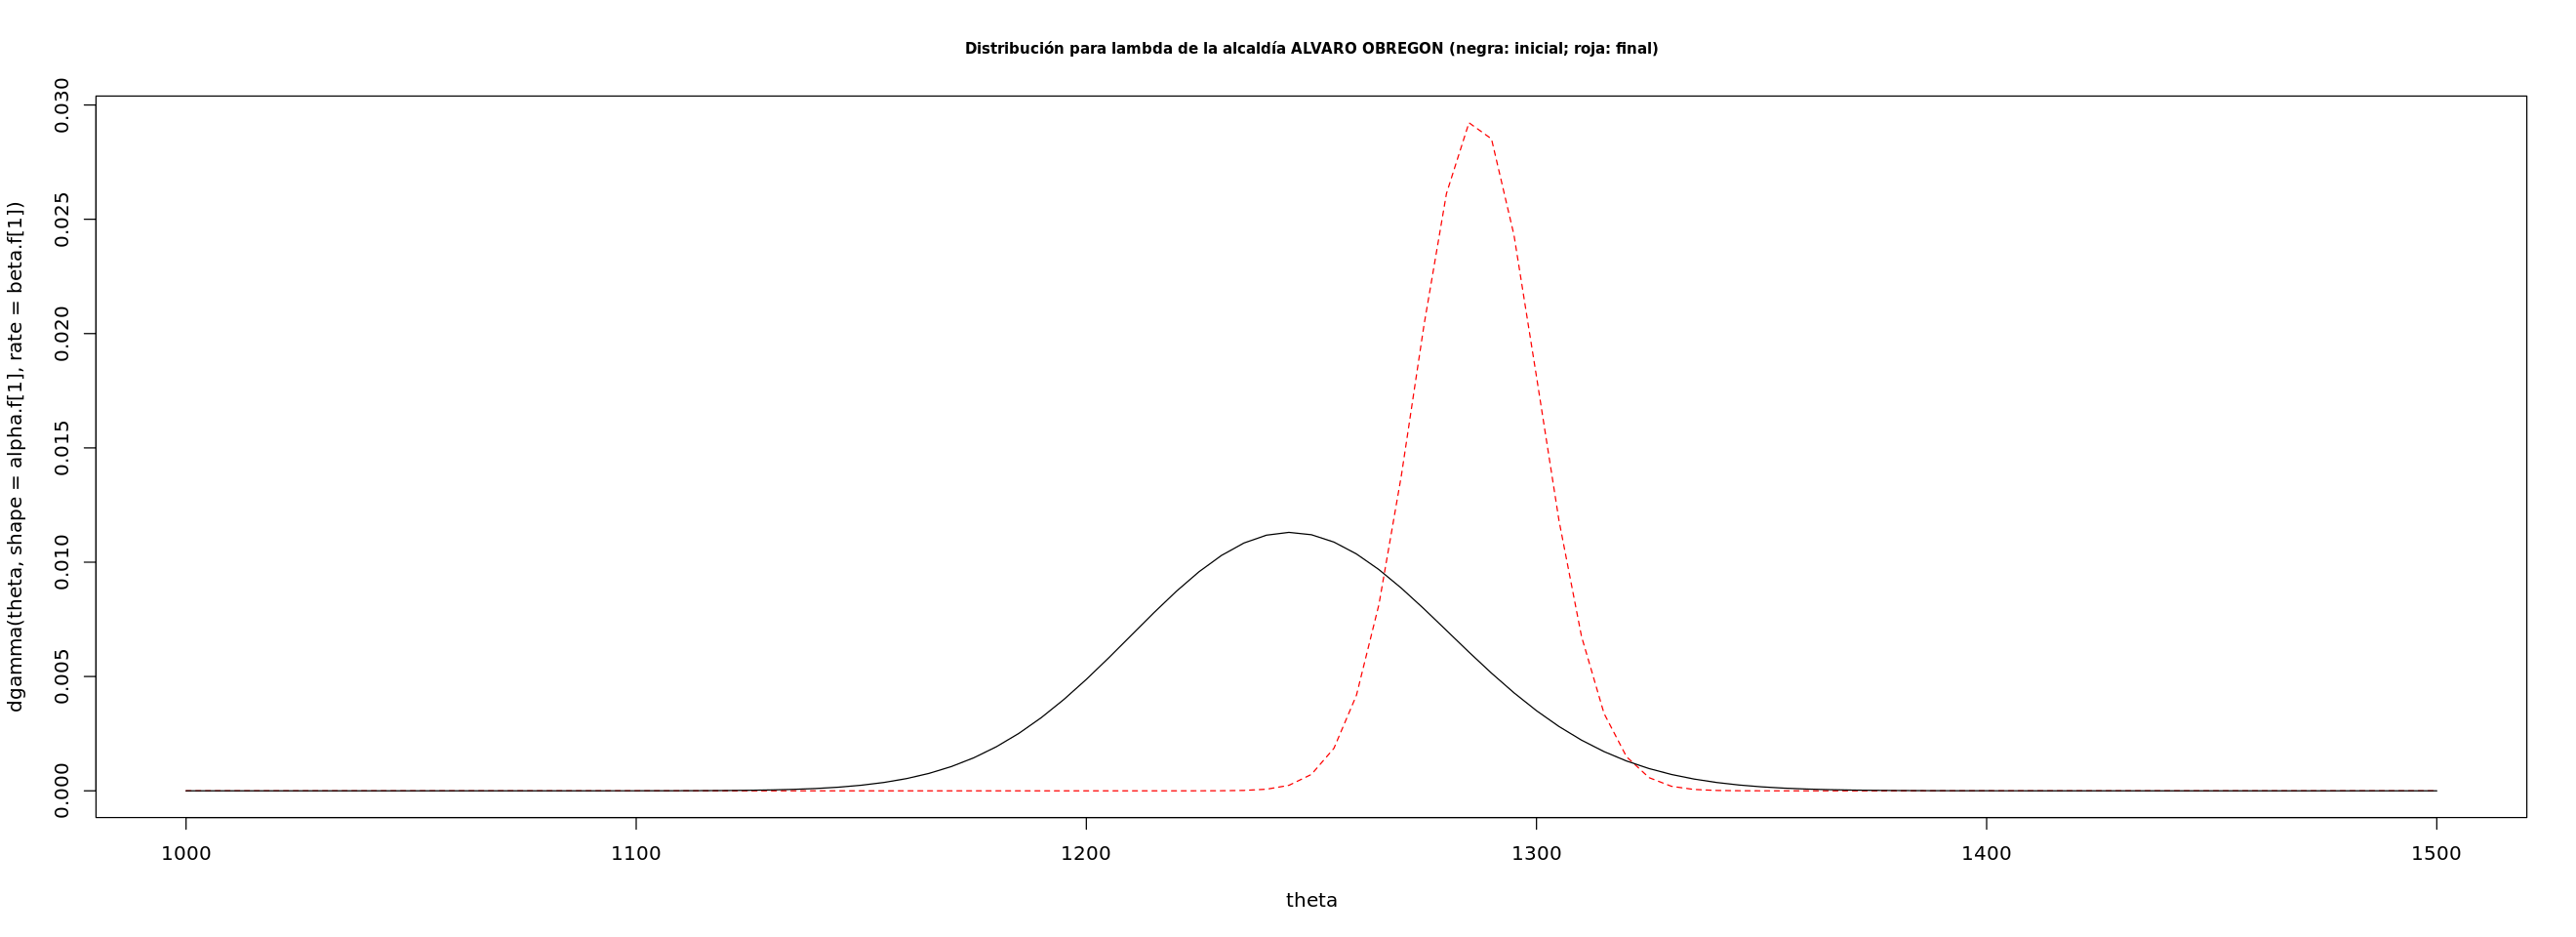

In [65]:
curve(dgamma(theta, shape = alpha.f[1], rate = beta.f[1]), from = 1000, to = 1500, col = 2, lty = 2, xname = 'theta')
curve(dgamma(theta, shape = alpha.i[1], rate = beta.i[1]), add = TRUE, xname = 'theta', ylab = 'Density')
title(main=paste0('Distribución para lambda de la alcaldía ALVARO OBREGON (negra: inicial; roja: final)' ), cex.main=0.75)

En la tabla siguiente se reporta el valor esperado del valor de lambda para cada distribución poisson de cada Alcaldía:

In [66]:
lambda.e <- alpha.f/beta.f

res.alc <- denuncias %>%
    group_by(Alcaldía) %>%
    summarise(Mean = mean(Delitos))
res.alc <- cbind(res.alc, Lambda = lambda.e)
res.alc

`summarise()` ungrouping output (override with `.groups` argument)



Alcaldía,Mean,Lambda
<fct>,<dbl>,<dbl>
ALVARO OBREGON,1255.7,1286.7
AZCAPOTZALCO,926.3,830.2
BENITO JUAREZ,1679.5,1549.4
COYOACAN,1261.2,1162.7
CUAJIMALPA DE MORELOS,265.5,270.3
CUAUHTEMOC,2967.2,2706.9
GUSTAVO A MADERO,1884.7,1849.5
IZTACALCO,834.4,809.2
IZTAPALAPA,2780.0,2730.2


Se realiza el mismo análisis por mes y se excluye 2018 y 2019, se presentan los $6$ primeros registros:

In [67]:
denuncias3 <- denuncias %>%
    filter(año == 2017) %>%
    group_by(mes) %>%
    summarise(lambda = mean(Delitos))
head(denuncias3)

`summarise()` ungrouping output (override with `.groups` argument)



mes,lambda
<fct>,<dbl>
January,1037.4
February,977.7
March,1110.1
April,1028.0
May,1181.1
June,1158.9


Se establecé la información apriori de la manera siguiente:

In [68]:
alpha.i.m <- denuncias3$lambda
beta.i.m <- rep(1,nrow(denuncias3))

Se incorporar información siguiente para actualizar los hiperparámetros (e presentan los primeros 6 registros):

In [69]:
obs.2019.m <- denuncias %>%
    filter(año != 2017) %>%
    group_by(mes) %>%
    summarise(x = sum(Delitos),
              n = n())
head(obs.2019.m)

`summarise()` ungrouping output (override with `.groups` argument)



mes,x,n
<fct>,<int>,<int>
January,33436,32
February,37265,32
March,40177,32
April,37879,32
May,40175,32
June,35086,32


Se actualizan los hiperparámetros

In [70]:
alpha.f.m <- alpha.i.m + obs.2019.m$x
beta.f.m <- beta.i.m + obs.2019.m$n

En la gráfica siguiente se contrastan la distribuciones inicial y final para el parámetro lambda del mes de enero.

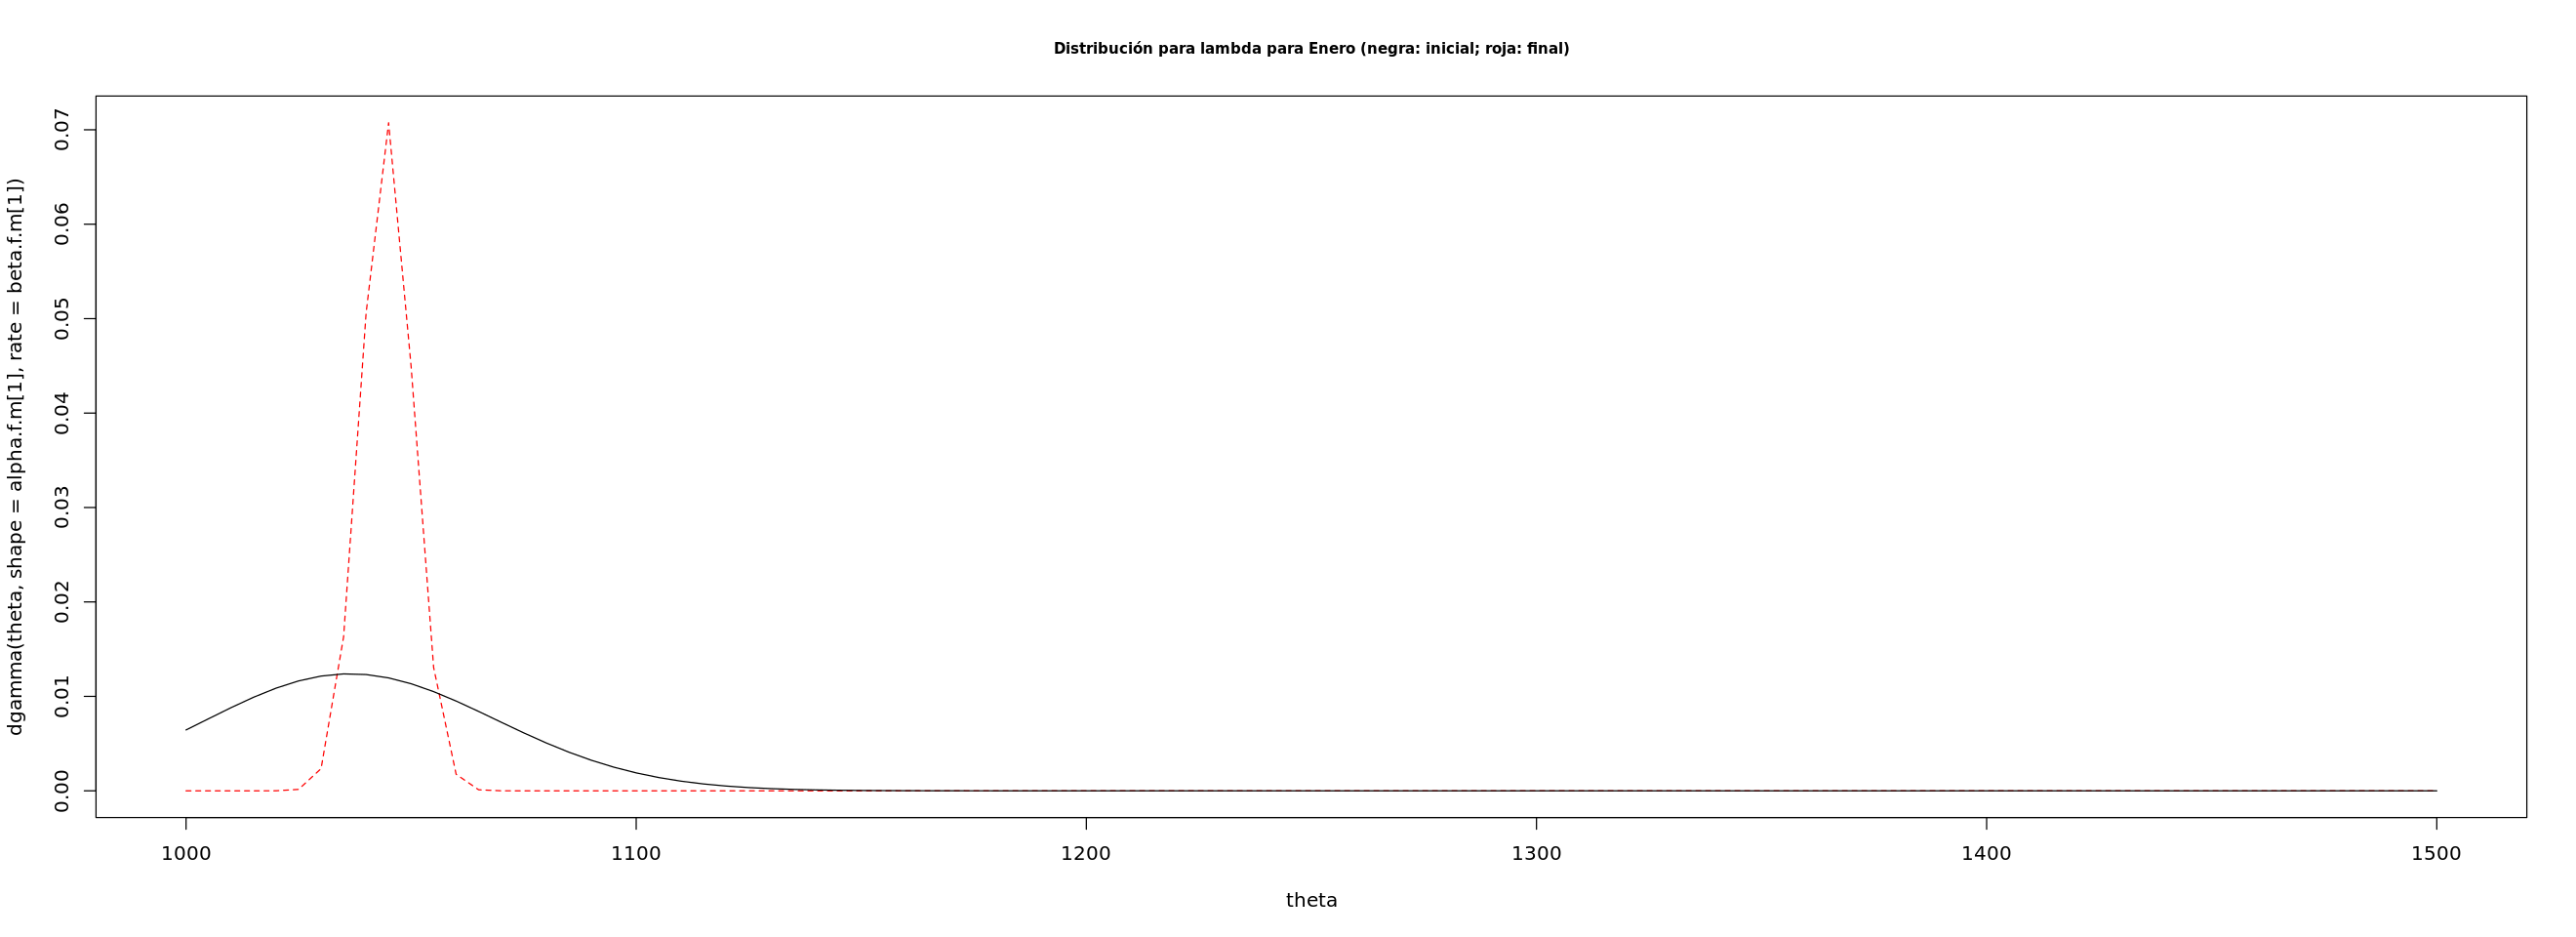

In [71]:
curve(dgamma(theta, shape = alpha.f.m[1], rate = beta.f.m[1]), from = 1000, to = 1500, col = 2, lty = 2, xname = 'theta')
curve(dgamma(theta, shape = alpha.i.m[1], rate = beta.i.m[1]), add = TRUE, xname = 'theta', ylab = 'Density')
title(main=paste0('Distribución para lambda para Enero (negra: inicial; roja: final)' ), cex.main=0.75)
lambda.e.m <- alpha.f.m/beta.f.m

En la tabla siguiente se reporta el valor esperado del valor de lambda para cada distribución poisson de cada mes:

In [72]:
res.m <- denuncias %>%
    group_by(mes) %>%
    summarise(Mean = mean(Delitos))
res.m <- cbind(res.m, Lambda = lambda.e.m)
res.m

`summarise()` ungrouping output (override with `.groups` argument)



mes,Mean,Lambda
<fct>,<dbl>,<dbl>
January,1042,1045
February,1102,1159
March,1207,1251
April,1132,1179
May,1231,1253
June,1117,1098
July,1202,1248
August,1246,1285
September,1182,1226


## Conclusiones

Cómo podemos observar, la tecnología nos proporciona en la actualidad herramientas capaces de apouyarnos en una buena cantidad de análisis, los cuales apoyan en la visualizar el mismo problema desde varios aspectos, permitiendono centrar más en el análisis, transformación y toma de deciciones que en el tratamiento de la información, lo cuál nos brinda la oportunidad de realizar proyectos sumamente enriquecidos desde diversos aspectos.